In [550]:
import torch
SEED = 567816 

import os
import random
import numpy as np
import torch
import sklearn
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [551]:
from jax import tree_util
tree_map = tree_util.tree_map


Using random_state = 567816
y_train_mean (mean of log(y_train_raw)): 0.5733967589120665
Train samples: 16512
Test samples: 4128
Shapes w/ intercept: (16512, 9) (4128, 9)
Bootstrap 1 shape: X=(16512, 9), y=(16512,)
Bootstrap 2 shape: X=(16512, 9), y=(16512,)
Bootstrap 3 shape: X=(16512, 9), y=(16512,)
Bootstrap 4 shape: X=(16512, 9), y=(16512,)
Bootstrap 5 shape: X=(16512, 9), y=(16512,)
Bootstrap 6 shape: X=(16512, 9), y=(16512,)
Bootstrap 7 shape: X=(16512, 9), y=(16512,)
Bootstrap 8 shape: X=(16512, 9), y=(16512,)
Bootstrap 9 shape: X=(16512, 9), y=(16512,)
Bootstrap 10 shape: X=(16512, 9), y=(16512,)


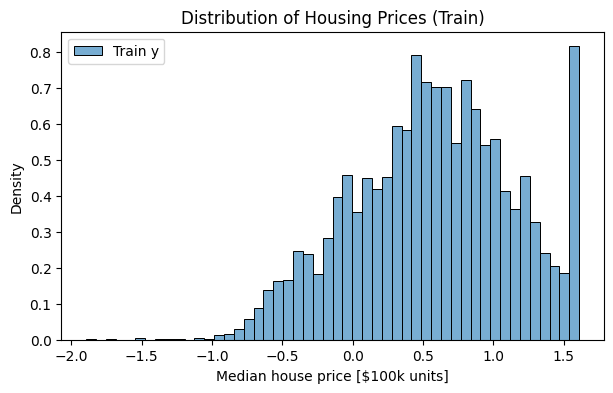

Max y: 5.00001
log(std(y_train)): -0.5601218094396596


In [552]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo 

california = fetch_california_housing(as_frame=False) 
X = california.data          
y = california.target        

# --- Train/test split ---
import time
seed = SEED #int(time.time())
print("Using random_state =", seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=seed
)

y_train_raw = y_train.copy()
y_test_raw  = y_test.copy()
# Apply log transform to targets
y_train = np.log(y_train)
y_test  = np.log(y_test)
y_train_mean = y_train.mean()
y_train_std = y_train.std()
print("y_train_mean (mean of log(y_train_raw)):", y_train_mean)


#y_train = y_train - y_train_mean
#y_test = y_test - y_train_mean

print("Train samples:", len(y_train))
print("Test samples:", len(y_test))

# --- Standardize features (but NOT target) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Add intercept column AFTER scaling ---
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_scaled = add_intercept(X_train_scaled)
X_test_scaled  = add_intercept(X_test_scaled)

print("Shapes w/ intercept:", X_train_scaled.shape, X_test_scaled.shape)

# --- Bootstraps ---
n_bootstraps = 10
n_train = len(y_train)

base_ss = np.random.SeedSequence(SEED)
child_ss = base_ss.spawn(n_bootstraps)

bootstraps = []
for b, ss in enumerate(child_ss, start=1):
    rng = np.random.default_rng(ss)
    idx = rng.integers(0, n_train, size=n_train, endpoint=False)
    X_bs = X_train_scaled[idx]
    y_bs = y_train[idx]
    bootstraps.append((X_bs, y_bs))
    print(f"Bootstrap {b} shape: X={X_bs.shape}, y={y_bs.shape}")

# --- Plot target distribution ---
plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=50, stat="density", alpha=0.6, label="Train y")
plt.title("Distribution of Housing Prices (Train)")
plt.xlabel("Median house price [$100k units]")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Debug info ---
y_max = max(y)
print("Max y:", y_max)
print("log(std(y_train)):", np.log(y_train.std()))

X_train_np = X_train_scaled
X_test_np  = X_test_scaled
y_train_np = y_train
y_test_np  = y_test
y_train_var = y_train_np.var()



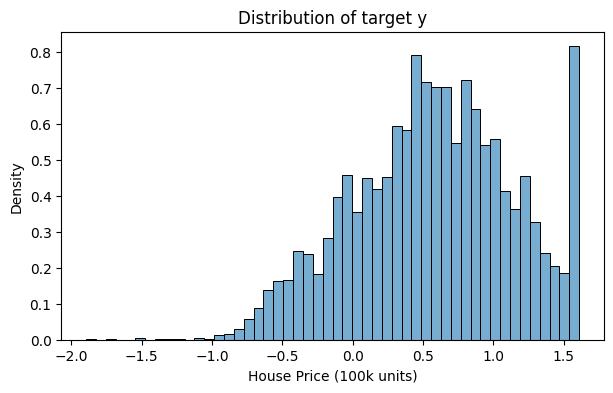

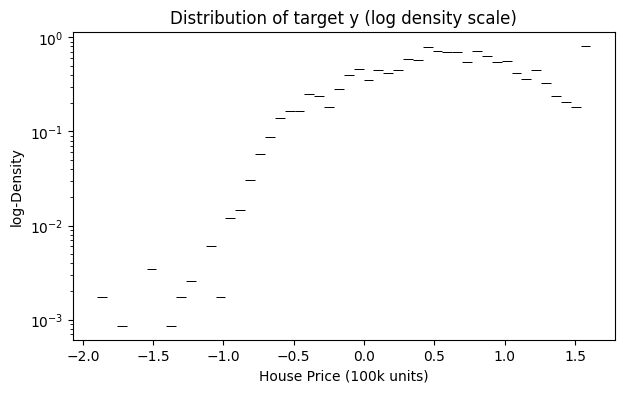

Skewness: -0.17405263590194683
Kurtosis: -0.4413185984312671


/var/folders/wl/l6v7zb5d5hv77sr6wky_w9km0000gn/T/ipykernel_10895/496774952.py:21: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(y_train), bins=50, stat="density", alpha=0.6, color="orange")
/var/folders/wl/l6v7zb5d5hv77sr6wky_w9km0000gn/T/ipykernel_10895/496774952.py:21: RuntimeWarning: invalid value encountered in log
  sns.histplot(np.log(y_train), bins=50, stat="density", alpha=0.6, color="orange")


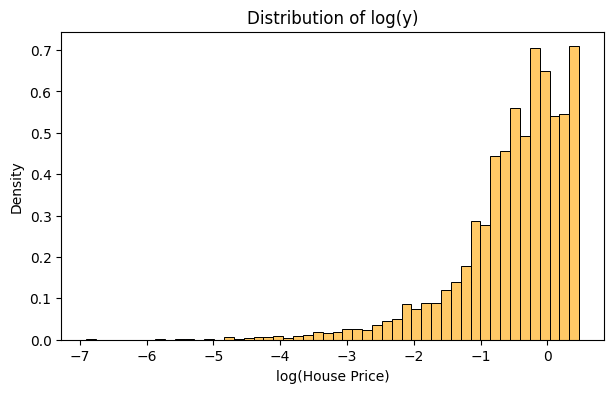

In [553]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=50, stat="density", alpha=0.6)
plt.title("Distribution of target y")
plt.xlabel("House Price (100k units)")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=50, stat="density", alpha=0.6, log_scale=(False, True))
plt.title("Distribution of target y (log density scale)")
plt.xlabel("House Price (100k units)")
plt.ylabel("log-Density")
plt.show()
from scipy.stats import skew, kurtosis
print("Skewness:", skew(y_train))
print("Kurtosis:", kurtosis(y_train))
plt.figure(figsize=(7,4))
sns.histplot(np.log(y_train), bins=50, stat="density", alpha=0.6, color="orange")
plt.title("Distribution of log(y)")
plt.xlabel("log(House Price)")
plt.ylabel("Density")
plt.show()


In [554]:
import numpy as np
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(y_train.reshape(-1,1))
sigma_mmd = np.median(dists)
print(sigma_mmd)

0.5588630592585565


In [555]:
#y_log = np.log(y_train)
#y_log_c = y_log - y_log.mean()

import numpy as np
import torch

n_features = X_train_np.shape[1]
prior_mean_beta = torch.zeros(n_features, dtype=torch.float32)
prior_mean_beta[0] = y_train_np.mean()  # Set intercept to empirical mean of log(y)

prior_cov_beta = torch.diag(torch.tensor([2.0] + [1.0]*(n_features-1), dtype=torch.float32))  
prior_cov_inv = torch.inverse(prior_cov_beta)
logdet_prior_cov = torch.log(torch.diag(prior_cov_beta)).sum()

# ----- Sigma^2 prior (Inverse-Gamma) -----
alpha0 = torch.tensor(2.1, dtype=torch.float32)  # Changed from 2.0 for finite variance
var_y = np.var(y_train_np, ddof=1)
beta0 = torch.tensor((alpha0 - 1.0) * var_y, dtype=torch.float32)





/var/folders/wl/l6v7zb5d5hv77sr6wky_w9km0000gn/T/ipykernel_10895/2237512672.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta0 = torch.tensor((alpha0 - 1.0) * var_y, dtype=torch.float32)


In [556]:
import torch
import torch.nn as nn
import torch.optim as optim
BATCH_SIZE = 64
MC_SAMPLES = 100
STEPS      = 1000
LR         = 1e-3

torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"Running deterministically with SEED={SEED}")

class VariationalLinearRegression(nn.Module):
    def __init__(self, n_features, init_m_beta=None, init_log_s_beta=-2.0,
                 init_m_log_sigma2=0.0, init_log_s_log_sigma2=-2.0, device="cpu"):
        super().__init__()
        
        if init_m_beta is None:
            init_m_beta = np.zeros(n_features)
        self.m_beta     = nn.Parameter(torch.tensor(init_m_beta, dtype=torch.float32, device=device))
        self.log_s_beta = nn.Parameter(torch.ones(n_features, device=device) * init_log_s_beta)

        self.m_logsig     = nn.Parameter(torch.tensor(float(init_m_log_sigma2), device=device))
        self.log_s_logsig = nn.Parameter(torch.tensor(float(init_log_s_log_sigma2), device=device))

    def sample_beta(self, num_samples=1):
        eps = torch.randn((num_samples, len(self.m_beta)), device=self.m_beta.device)
        return self.m_beta + torch.exp(self.log_s_beta) * eps

    def sample_sigma2(self, num_samples=1, sigma_min=1e-6):
        eps = torch.randn(num_samples, device=self.m_logsig.device)
        log_sigma2 = self.m_logsig + torch.exp(self.log_s_logsig) * eps
        sigma2 = torch.exp(log_sigma2)
        return torch.clamp(sigma2, min=sigma_min)

    @staticmethod
    def kl_divergence_beta(q, prior_mean, prior_cov, prior_cov_inv, logdet_prior_cov):
        p = q.m_beta.numel()
        q_var = torch.exp(2 * q.log_s_beta)    # (p,)
        q_cov = torch.diag(q_var)
        diff  = (q.m_beta - prior_mean).unsqueeze(1)

        term_trace = torch.trace(prior_cov_inv @ q_cov)
        term_quad  = (diff.T @ prior_cov_inv @ diff).squeeze()
        term_logdet = logdet_prior_cov - torch.sum(torch.log(q_var))

        kl = 0.5 * (term_trace + term_quad - p + term_logdet)
        return kl

    @staticmethod
    def kl_divergence_sigma2(q, alpha0, beta0):
        m = q.m_logsig
        v = torch.exp(2 * q.log_s_logsig)

        # Entropy of LogNormal
        entropy_q = 0.5 * torch.log(2 * torch.pi * torch.e * v) + m

        # Expectations under q
        E_log_sigma2 = m
        E_inv_sigma2 = torch.exp(-m + 0.5 * v)

        # E_q[log p(sigma²)] for InvGamma
        E_log_p = (alpha0 * torch.log(beta0)
                   - torch.lgamma(alpha0)
                   - (alpha0 + 1.0) * E_log_sigma2
                   - beta0 * E_inv_sigma2)

        E_log_q = -entropy_q
        return E_log_q - E_log_p



Running deterministically with SEED=567816


In [557]:
import torch

def expected_nll_regression(model, X, y):
    """
    Computes E_q[NLL] exactly (closed form),
    for Gaussian regression with diagonal Gaussian q(w)
    and LogNormal q(sigma²).
    """

    n = y.numel()

    # === q(w) parameters ===
    m_beta = model.m_beta                        # (d,)
    r = torch.exp(2 * model.log_s_beta)          # diagonal variances (d,)

    # === q(sigma²) LogNormal parameters ===
    m_s = model.m_logsig                         # mean of log sigma²
    v_s = torch.exp(2 * model.log_s_logsig)      # variance of log sigma²

    E_log_sigma2 = m_s
    E_inv_sigma2 = torch.exp(-m_s + 0.5 * v_s)

    # === Expectation of squared residual ===
    # First term: || y - X m_beta ||^2
    resid_mean = y - X @ m_beta                  # shape (n,)
    S1 = (resid_mean ** 2).sum()

    # Second term: sum_i x_i^T diag(r) x_i
    # = sum_j r_j * sum_i x_ij^2
    s = (X ** 2).sum(dim=0)                      # shape (d,)
    S2 = (r * s).sum()

    # === Closed-form expected NLL ===
    const_term = 0.5 * n * torch.log(torch.tensor(2 * torch.pi, device=X.device))
    quad_term  = 0.5 * E_inv_sigma2 * (S1 + S2)
    log_det_term = 0.5 * n * E_log_sigma2 

    return const_term + quad_term + log_det_term



def beta_loss_regression(X, y, beta_vec, sigma2, beta_div):
    mu = X @ beta_vec           
    resid2 = (y - mu) ** 2      
    b = beta_div
    c = (2 * torch.pi * sigma2) ** (-(b - 1) / 2)  
    term1 = -(1.0 / (b - 1.0)) * c * torch.exp(-0.5 * (b - 1.0) * resid2 / sigma2)
    term2 = (1.0 / (b ** 1.5)) * c              
    return (term1 + term2).sum()


def gamma_loss_regression(X, y, beta, sigma2, gamma):
    n = y.shape[0]
    gamma_t = torch.tensor(gamma, dtype=X.dtype, device=X.device)
    mu = X @ beta
    r2 = (y - mu)**2
    log_f_gamma = -(gamma_t/2) * torch.log(2 * np.pi * sigma2) \
                  - gamma_t * r2 / (2 * sigma2)
    
    term1 = (
    -(1/gamma_t) * (torch.logsumexp(log_f_gamma, dim=0) 
                    - torch.log(torch.tensor(float(n), device=X.device)))
    # + 0.5 * torch.log(2 * np.pi * sigma2)
    )

    log_int = -(gamma_t/2) * torch.log(2 * np.pi * sigma2) \
              - 0.5 * torch.log(1 + gamma_t) 
    
    term2 = (1/(1+gamma_t)) * log_int
    
    return term1 + term2






In [558]:
def divergence_kl(q,
                  prior_mean_beta,
                  prior_cov_beta,
                  prior_cov_inv,
                  logdet_prior_cov,
                  alpha0,
                  beta0):
    """
    KL divergence term for regression with conjugate priors:
      q(β)       vs N(prior_mean_beta, prior_cov_beta)
      q(sigma^2) vs InvGamma(alpha0, beta0)
    """
    device = q.m_beta.device

    kl_beta = VariationalLinearRegression.kl_divergence_beta(
        q,
        prior_mean=prior_mean_beta.to(device),
        prior_cov=prior_cov_beta.to(device),
        prior_cov_inv=prior_cov_inv.to(device),
        logdet_prior_cov=logdet_prior_cov.to(device)
    )

    kl_sigma2 = VariationalLinearRegression.kl_divergence_sigma2(
        q,
        alpha0.to(device),
        beta0.to(device)
    )

    return kl_beta + kl_sigma2




In [559]:
from torch.utils.data import DataLoader, TensorDataset

def make_minibatches(X_numpy, y_numpy, batch_size=64, shuffle=True, device="cpu"):
    """
    Wrap numpy arrays into a DataLoader for minibatching.
    """
    X = torch.tensor(X_numpy, dtype=torch.float32, device=device)
    y = torch.tensor(y_numpy, dtype=torch.float32, device=device)
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False, pin_memory=(device=="cuda"))


In [560]:
import torch
import torch.optim as optim
import numpy as np

def train_gvi_regression(
    X_numpy, y_numpy,
    loss_type="nll",            
    gamma=0.9, 
    beta=1.1,                 
    steps=1000, lr=1e-3,
    batch_size=64,  # Used for beta/gamma only
    mc_samples=10,
    prior_mean_beta=None, 
    prior_cov_beta=None, 
    prior_cov_inv=None, 
    logdet_prior_cov=None,
    alpha0=None, beta0=None,
    device="cpu"
):
    """
    Train variational inference for Bayesian linear regression.
    
    - NLL: Full-batch (closed-form gradient)
    - Beta/Gamma: Mini-batch (expensive MC sampling)
    """
    if hasattr(X_numpy, "values"): 
        X_numpy = X_numpy.values
    if hasattr(y_numpy, "values"): 
        y_numpy = y_numpy.values
    
    n, p = X_numpy.shape
    
    q = VariationalLinearRegression(p, device=device).to(device)
    opt = optim.Adam(q.parameters(), lr=lr)
    
    losses = []
    if loss_type == "nll":
        X_tensor = torch.tensor(X_numpy, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_numpy, dtype=torch.float32).to(device)
        
        for step in range(steps):
            opt.zero_grad()

            data_term = expected_nll_regression(q, X_tensor, y_tensor)
            
            kl = divergence_kl(
                q,
                prior_mean_beta,
                prior_cov_beta,
                prior_cov_inv,
                logdet_prior_cov,
                alpha0,
                beta0
            )
            
            obj = data_term + kl
            obj.backward()
            opt.step()
            
            losses.append(obj.item())
            
            # Early stopping
            if not torch.isfinite(obj):
                print(f"⚠️ NaN at step {step}")
                break
            
            if step > 10 and abs(losses[-1] - losses[-2]) < 1e-6:
                print(f"✅ Converged at step {step}")
                break
    elif loss_type in ["beta", "gamma"]:
        loader = make_minibatches(X_numpy, y_numpy, batch_size=batch_size, 
                                  shuffle=True, device=device)
        
        if loss_type == "beta":
            loss_fn = lambda Xb, yb, b_s, s2_s: beta_loss_regression(Xb, yb, b_s, s2_s, beta)
        else:  # gamma
            loss_fn = lambda Xb, yb, b_s, s2_s: gamma_loss_regression(Xb, yb, b_s, s2_s, gamma)
        
        step = 0
        while step < steps:
            for Xb_cpu, yb_cpu in loader:
                Xb = Xb_cpu.to(device)
                yb = yb_cpu.to(device)
                
                opt.zero_grad()
                K = Xb.shape[0]
                mc_vals = []
                for _ in range(mc_samples):
                    beta_s = q.sample_beta(1).squeeze(0)   
                    sigma2_s = q.sample_sigma2(1).squeeze(0)  
                    ell_sum_batch = loss_fn(Xb, yb, beta_s, sigma2_s)
                    mc_vals.append((n / K) * ell_sum_batch)  
                
                data_term = torch.stack(mc_vals).mean()
                
                kl = divergence_kl(
                    q,
                    prior_mean_beta,
                    prior_cov_beta,
                    prior_cov_inv,
                    logdet_prior_cov,
                    alpha0,
                    beta0
                )
                
                obj = data_term + kl
                obj.backward()
                opt.step()
                
                losses.append(obj.item())
                step += 1
                
                if step >= steps:
                    break
    
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")
    
    print(f"Training complete: {len(losses)} steps")
    return q


In [561]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
def crps_gaussian_mixture(weights, means, sigmas, y_obs):
    """
    CRPS for scalar Gaussian mixture (numerically stable)
    
    Uses the energy representation:
    CRPS(F, y) = E[|X - y|] - (1/2)E[|X - X'|]
    
    Args:
        weights: [K] - mixture weights
        means: [K] - scalar means  
        sigmas: [K] - standard deviations
        y_obs: scalar observation
    """
    K = weights.shape[0]
    EPS = 1e-10
    
    # Clamp sigmas to avoid numerical issues
    sigmas = jnp.maximum(sigmas, EPS)
    
    # === Term 1: E[|X - y|] where X ~ mixture ===
    # For each component k: E[|N(μₖ, σₖ²) - y|]
    def term1_component(w_k, mu_k, sigma_k):
        z = (y_obs - mu_k) / sigma_k
        # Clip to avoid overflow in cdf/pdf
        #z = jnp.clip(z, -30.0, 30.0)
        
        # E[|N(μ,σ²) - y|] = σ · [z(2Φ(z) - 1) + 2φ(z) - 1/√π]
        cdf_z = jax.scipy.stats.norm.cdf(z)
        pdf_z = jax.scipy.stats.norm.pdf(z)
        
        crps_component = sigma_k * (
            z * (2.0 * cdf_z - 1.0) + 
            2.0 * pdf_z - 
            1.0 / jnp.sqrt(jnp.pi)
        )
        
        return w_k * crps_component
    
    term1 = jnp.sum(jax.vmap(term1_component)(weights, means, sigmas))
    
    # === Term 2: (1/2)E[|X - X'|] where X, X' ~ mixture independently ===
    # For components i, j: E[|N(μᵢ, σᵢ²) - N(μⱼ, σⱼ²)|]
    # This is E[|Z|] where Z ~ N(μᵢ - μⱼ, σᵢ² + σⱼ²)
    def term2_pair(w_i, mu_i, sigma_i, w_j, mu_j, sigma_j):
        # Difference of two independent Gaussians
        mu_diff = mu_i - mu_j
        sigma_sum_sq = sigma_i**2 + sigma_j**2
        sigma_combined = jnp.sqrt(sigma_sum_sq)
        sigma_combined = jnp.maximum(sigma_combined, EPS)
        
        # E[|N(μ_diff, σ_combined²)|] 
        z = mu_diff / sigma_combined
        #z = jnp.clip(z, -30.0, 30.0)
        
        cdf_z = jax.scipy.stats.norm.cdf(z)
        pdf_z = jax.scipy.stats.norm.pdf(z)
        
        # E[|Z|] = σ_Z · [z(2Φ(z) - 1) + 2φ(z)]
        expected_abs = sigma_combined * (
            z * (2.0 * cdf_z - 1.0) + 
            2.0 * pdf_z
        )
        
        return w_i * w_j * expected_abs
    
    # Compute all pairwise terms
    term2 = 0.5 * jnp.sum(
        jax.vmap(
            jax.vmap(term2_pair, (None, None, None, 0, 0, 0)),
            (0, 0, 0, None, None, None)
        )(weights, means, sigmas, weights, means, sigmas)
    )
    
    crps = term1 - term2
    
    # Numerical safety: return large penalty if NaN
    return jnp.where(jnp.isnan(crps), 1e10, crps)

In [562]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from functools import partial
import numpy as np
import matplotlib.pyplot as plt



def build_gaussian_lr(y0, ts, params, key = None, n_samples=1, add_noise=False):
    if params.ndim == 1:
        beta = params[:-1]
        sigma = jnp.exp(params[-1])
        mean_pred = ts @ beta  
        return mean_pred 
    else:
        betas = params[:, :-1]           
        sigmas = jnp.exp(params[:, -1])    
        means = ts @ betas.T               
        return means



import jax
import numpy as np

import jax.random as jrandom
import jax.numpy as jnp
from functools import partial

def build_func_dict(obs, ts, ls2, y0, func, product=True):
    #normal = lambda x, mu, s2: jnp.exp(jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2))
    normal = lambda x, mu, s2: jnp.exp(jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2 + 0.5 * jnp.log(2*jnp.pi*ls2)))
    lognormal = lambda x, mu, s2: jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2)
    kernel = normal if product else normal0

    def bayes_posterior(params):
        ys = func(y0, ts, params, add_noise=False)  
        if ys.ndim > 1:
            ys = ys[0]
        sigma = jnp.exp(params[-1])
        s2 = sigma**2
        loglik = jnp.sum(
            -0.5 * jnp.log(2 * jnp.pi * s2)
            -0.5 * ((ys - obs)**2) / s2
        )
        logprior = -0.5 * jnp.sum(params**2)
        return loglik + logprior

    def mmd_posterior(params):
            logprior = lognormal(params, 0.0, 1.0)
            sigma = jnp.exp(params[-1])
            s2 = sigma**2
            tj0 = func(y0, ts, params)
            if tj0.ndim > 1:
                tj0 = tj0[0]
            def calculate_V(tj):
                kxy = jax.vmap(kernel, (0, 0, None))(obs, tj, s2 + ls2)
                return jnp.sum(kxy)
        
            def calculate_W(tj1, tj2):
                kxy = jax.vmap(kernel, (0, 0, None))(tj2, tj1, 2 * s2 + ls2)
                return jnp.sum(kxy)
                
            Vs = calculate_V(tj0)
            #Ws = calculate_W(tj0, tj0)
            return Vs# - 0.5 * Ws

    def particle_updates_marginalized(params_set, params_set2=None, sum=True):
        n_particles = params_set.shape[0]
        if params_set2 is None:
            params_set2 = params_set
        params_set2 = jax.lax.stop_gradient(params_set2)

        trajs1 = jax.vmap(func, (None, None, 0))(y0, ts, params_set)
        trajs2 = jax.vmap(func, (None, None, 0))(y0, ts, params_set2)

        sigmas1 = jnp.exp(params_set[:, -1])   
        sigmas2 = jnp.exp(params_set2[:, -1])  
        s2s1 = sigmas1**2
        s2s2 = sigmas2**2
        def calculate_V(obs, tj, s2_i):
            kxy = jax.vmap(kernel, (0, 0, None))(obs, tj, s2_i + ls2)
            return jnp.sum(kxy)

        Vs = jax.vmap(calculate_V, (None, 0, 0))(obs, trajs1, s2s1)
        def calculate_W(tj1, tj2, s2_i, s2_j):
            s2_combined = (s2_i + s2_j) / 2
            kxy = jax.vmap(kernel, (0, 0, None))(tj2, tj1, 2 * s2_combined + ls2)
            return jnp.sum(kxy)
        Ws = jax.vmap(
            jax.vmap(calculate_W, (None, 0, None, 0)),  
            (0, None, 0, None)                           
        )(trajs1, trajs2, s2s1, s2s2)

        Ws = Ws.at[jnp.diag_indices_from(Ws)].set(0.0)
        Ws = jnp.sum(Ws, 1) / jnp.maximum(n_particles - 1, 1)

        if sum:
            return jnp.sum(Vs - Ws)
        return (Vs - Ws)
    
    import jax.scipy.stats as stats

    def crps_posterior(params):
        ys = func(y0, ts, params, add_noise=False)
        if ys.ndim > 1:
            ys = ys[0]
        sigma = jnp.exp(params[-1])
        z = (obs - ys) / sigma
        pdf = stats.norm.pdf(z)
        cdf = stats.norm.cdf(z)
        crps_vals = sigma * (z * (2 * cdf - 1) + 2 * pdf - 1.0 / jnp.sqrt(jnp.pi))
        return -jnp.sum(crps_vals) 

    def crps_mixture_objective(params_set):
        n_particles = params_set.shape[0]
        weights = jnp.ones(n_particles) / n_particles
        trajs = jax.vmap(lambda p: func(y0, ts, p, add_noise=False))(params_set)
        sigmas = jnp.exp(params_set[:, -1])
        if trajs.ndim == 2:
            trajs = trajs[:, :, None]
        def crps_at_time_t(t_idx):
            y_t = obs[t_idx]
            means_t = trajs[:, t_idx, :] 
            if jnp.ndim(y_t) == 0: 
                y_t = jnp.array([y_t])
            
            return crps_gaussian_mixture(weights, means_t, sigmas, y_t)
        
        crps_vals = jax.vmap(crps_at_time_t)(jnp.arange(len(obs)))
        avg_crps = jnp.mean(crps_vals)
        logprior = jnp.mean(-0.5 * jnp.sum(params_set**2, axis=1))
        return -avg_crps + logprior



    func_dict = {
        'bayes': jax.jit(bayes_posterior),
        'mmd-bayes': jax.jit(mmd_posterior),
        'crps-bayes': jax.jit(crps_posterior),
        'pcuq': jax.jit(partial(particle_updates_marginalized, sum=True)),
        'pcuq-crps': jax.jit(crps_mixture_objective),
    }

        
    return func_dict



def mala(func, n_iters, dt0, params_init, reg_const, key, multi=False):
    g0 = jax.value_and_grad(func, 0)
    gfunc = jax.vmap(g0, 0) if multi else jax.value_and_grad(func)
    grad_norms = [] 
    energies = []
    params = params_init
    trace = []
    n_particles = params_init.shape[0] if multi else 1

    def logratio(pold, pnew, dt):
        lold, gold = g0(pold)
        lnew, gnew = g0(pnew)
        lold -= 0.5 * reg_const * jnp.sum(jnp.square(pold))
        lnew -= 0.5 * reg_const * jnp.sum(jnp.square(pnew))
        gold -= reg_const * pold
        gnew -= reg_const * pnew
        
        t1 = lnew - lold
        q1 = -0.25 * jnp.sum(jnp.square(pold - pnew - dt * gnew))
        q2 = -0.25 * jnp.sum(jnp.square(pnew - pold - dt * gold))
        return t1 / reg_const + (q1 - q2) / (reg_const * dt)

    logratio = jax.vmap(logratio, (0, 0, None)) if multi else logratio

    hist = []
    window = 10

    for i in range(n_iters):
        rng, key = jrandom.split(key)
        ll, g = gfunc(params)
        grad_norm = jnp.linalg.norm(g)
        grad_norms.append(float(grad_norm))
        params_new = params + dt0 * g - dt0 * reg_const * params + jnp.sqrt(2 * reg_const * dt0) * jrandom.normal(rng, params.shape)
        rng, key = jrandom.split(key)
        
        energy = -ll
        energy_scalar = jnp.mean(energy)
        energies.append(float(energy_scalar))
        lr = logratio(params, params_new, dt0)
        
        if multi:
            flag = jnp.where(jnp.log(jrandom.uniform(rng, lr.shape)) <= lr)[0]
            params = params.at[flag, :].set(params_new[flag, :])
            hist.append(flag.shape[0] / n_particles)
        else:
            flag = (jnp.log(jrandom.uniform(rng, lr.shape)) <= lr)
            params = params_new if flag else params
            hist.append(flag+0.0)
            
        trace.append(params.copy())


        hist = hist[-window:]

        if len(hist) >= window and (i+1) % window == 0 and i >= 50:
            accept_rate = jnp.mean(jnp.array(hist))
            if hasattr(hist, 'logratios'):  
                recent_lr = jnp.array(hist.logratios[-window:])
                mean_lr = jnp.mean(recent_lr)
                
                if accept_rate < 0.15 and mean_lr < -5.0:
                    dt0 = max(dt0 * 0.7, 1e-6)
                elif accept_rate < 0.2 and mean_lr < -2.0:
                    dt0 = max(dt0 * 0.9, 1e-6)
                elif accept_rate > 0.8 and mean_lr > -0.5:
                    dt0 *= 1.2
                elif accept_rate > 0.6 and mean_lr > -1.0:
                    dt0 *= 1.05
          

        if (i+1) % 100 == 0:
            print('{}: {}'.format(i+1, jnp.mean(jnp.array(hist))))
            if multi:
                log_sigma_val = jnp.mean(params[:, -1])
            else:
                log_sigma_val = params[-1]
            log_sigma_val = jnp.ravel(log_sigma_val)[0]   
            print("log_sigma:", float(log_sigma_val))
            print("norn g:", jnp.linalg.norm(g))

    plt.figure(figsize=(8,4))
    plt.plot(grad_norms)
    plt.title("Gradient Norm Evolution (final)")
    plt.xlabel("Iteration")
    plt.ylabel("‖g‖₂")
    plt.grid(alpha=0.3)
    plt.show()
    plt.figure(figsize=(10, 4))
    plt.plot(energies, label="Energy (−log posterior)")
    plt.title("Energy Evolution ")
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    arr = np.array(trace)
    param_means = arr.mean(axis=1) if arr.ndim == 3 else arr
    plt.figure(figsize=(10, 6))
    for j in range(param_means.shape[1]):
        plt.plot(param_means[:, j], label=f"param {j}" if j < 5 else None)
    plt.xlabel("Iteration")
    plt.ylabel("Parameter value")
    plt.title("Final evolution of β and log σ")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()        
    return trace

def langevin(func, n_iters, dt0, params_init, reg_const, key, multi=False):
    gfunc = jax.value_and_grad(func, 0)
    gfunc = jax.vmap(gfunc, 0) if multi else gfunc
    
    params = params_init
    trace = []
    

    for i in range(n_iters):
        rng, key = jrandom.split(key)
        ll, g = gfunc(params)

        params_new = params + dt0 * g - dt0 * reg_const * params + jnp.sqrt(2 * reg_const * dt0) * jrandom.normal(rng, params.shape)
        params = params_new
        
        trace.append(params.copy())

        if (i+1) % 1000 == 0:
            print('{}: {}'.format(i+1, ll))
            
    return trace



In [563]:
import numpy as np
import torch

class BaggedVariationalPosterior:
    """
    Mixture of B variational posteriors q_b with equal weights 1/B.
    Sampling returns an i.i.d. draw from the mixture by partitioning S across components.
    """

    def __init__(self, components, rng=None):
        assert len(components) >= 1, "Need at least one posterior component"
        self.components = components
        self.rng = np.random.default_rng() if rng is None else rng
        # Try to detect device
        self.device = getattr(components[0], "device", None)
        if self.device is None and hasattr(components[0], "m_beta"):
            self.device = components[0].m_beta.device
        if self.device is None:
            self.device = torch.device("cpu")

    def _split_counts(self, S):
        """Randomly assign how many samples each component contributes."""
        B = len(self.components)
        if B == 1:
            return [S]
        probs = np.full(B, 1.0 / B)
        return list(self.rng.multinomial(S, probs))

    def sample_beta(self, S):
        counts = self._split_counts(S)
        betas = []
        for q, n_i in zip(self.components, counts):
            if n_i <= 0:
                continue
            b = q.sample_beta(n_i)
            # ensure (S, p) orientation
            if b.shape[0] < b.shape[1]:
                b = b.T
            betas.append(b.to(self.device))
        if not betas:
            raise RuntimeError("No beta samples drawn — check counts or model definitions.")
        return torch.cat(betas, dim=0)  # (S, p)

    def sample_sigma2(self, S):
        counts = self._split_counts(S)
        sig2 = []
        for q, n_i in zip(self.components, counts):
            if n_i <= 0:
                continue
            s2 = q.sample_sigma2(n_i).to(self.device)
            sig2.append(s2)
        if not sig2:
            raise RuntimeError("No sigma² samples drawn — check counts or model definitions.")
        return torch.cat(sig2, dim=0)



class BaggedPCUQ:
    def __init__(self, components, rng=None):
        assert len(components) >= 1, "Need at least one posterior component"
        self.components = []

        for q in components:
            if isinstance(q, dict):
                beta_s, sig2_s = q["beta_samples"], q["sigma2_samples"]
            else:
                beta_s, sig2_s = q

            # Ensure (S, p) shape for betas
            if beta_s.shape[0] < beta_s.shape[1]:
                beta_s = beta_s.T

            self.components.append((beta_s, sig2_s))

        self.device = self.components[0][0].device
        self.rng = np.random.default_rng() if rng is None else rng

    def sample_empirical(self, S):
        B = len(self.components)
        picks = self.rng.integers(0, B, size=S)

        betas_out, sig2_out = [], []
        for b in range(B):
            idx = np.where(picks == b)[0]
            if idx.size == 0:
                continue

            beta_b, sig2_b = self.components[b]
            n_avail = beta_b.shape[0]
            take = self.rng.integers(0, n_avail, size=idx.size)

            betas_out.append(beta_b[take].to(self.device))
            sig2_out.append(sig2_b[take].to(self.device))

        if not betas_out:
            raise RuntimeError("No samples drawn — all component pools empty or incompatible.")

        beta_cat = torch.cat(betas_out, dim=0)  # [S, p]
        sig2_cat = torch.cat(sig2_out, dim=0)   # [S]
        return beta_cat, sig2_cat


In [564]:
import torch
import numpy as np

def train_pvi(
    model, X_train, y_train,
    steps=1000,
    lr=1e-3,
    n_mc=50,
    lambda_reg=0.1,
    scoring="log",  # "log" or "crps"
    prior_mean_beta=None,
    prior_cov_beta=None,
    prior_cov_inv=None,
    logdet_prior_cov=None,
    alpha0=2.0, beta0=2.0,
    device="cpu",
    verbose=True,
):
    """
    Predictive Variational Inference (PVI) training loop (vectorized version).
    Faster version that avoids Python loops over data points.
    """

    # Move data to device
    X = torch.tensor(X_train, dtype=torch.float32, device=device)
    y = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    N = X.shape[0]

    for t in range(1, steps + 1):
        # =======================================================
        # (1) Monte Carlo samples from variational posterior
        # =======================================================
        beta_samples = model.sample_beta(n_mc)       # [S, p]
        sigma2_samples = model.sample_sigma2(n_mc)   # [S]
        sigma_samples = sigma2_samples.sqrt()        # [S]

        # =======================================================
        # (2) Predictive draws y = Xβ + ε
        # =======================================================
        y_pred = X @ beta_samples.T                  # [N, S]
        eps = torch.randn_like(y_pred) * sigma_samples
        y_draws = y_pred + eps

        # =======================================================
        # (3) Predictive scoring
        # =======================================================
        if scoring == "log":
            # Fully vectorized log predictive density
            comp = -0.5 * ((y - y_pred) ** 2 / sigma2_samples + torch.log(2 * torch.pi * sigma2_samples))
            # logsumexp over mixture components (S samples)
            logp = torch.logsumexp(comp, dim=1) - np.log(n_mc)
            loss_pred = -logp.mean()  # negative log-score

        elif scoring == "crps":
            # Empirical CRPS via pairwise distances (vectorized)
            y_expand = y_draws.unsqueeze(2)  # [N, S, 1]
            diff = torch.abs(y_expand - y_expand.transpose(1, 2))  # [N, S, S]
            term1 = torch.mean(torch.abs(y_draws - y), dim=1)      # [N]
            term2 = 0.5 * torch.mean(diff, dim=(1, 2))             # [N]
            crps_vals = term1 - term2
            loss_pred = crps_vals.mean()                           # scalar
        else:
            raise ValueError("scoring must be 'log' or 'crps'")

        # =======================================================
        # (4) KL regularization
        # =======================================================
        kl_beta = model.kl_divergence_beta(
            model, prior_mean_beta, prior_cov_beta, prior_cov_inv, logdet_prior_cov
        )
        kl_sigma = model.kl_divergence_sigma2(model, alpha0, beta0)
        kl_total = kl_beta + kl_sigma

        # =======================================================
        # (5) Combine and update
        # =======================================================
        loss = loss_pred + lambda_reg * kl_total

        opt.zero_grad()
        loss.backward()
        opt.step()

        if verbose and (t == 1 or t % (steps // 10) == 0):
            print(f"[{t:4d}/{steps}] {scoring.upper()} loss={loss_pred.item():.4f} | KL={kl_total.item():.4f}")

    return model



In [565]:
def train_bootstrap_posteriors(train_fn, X, y, B=20, rng=None, **kwargs):
    """
    Generic bootstrap: returns a list of posteriors for a given training function.
    For VI methods, train_fn returns a model object q with .sample_beta/.sample_sigma2.
    For PCUQ, train_fn returns (beta_samples, sigma2_samples) or a dict.
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(y)
    posteriors = []
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # sample with replacement
        Xb, yb = X[idx], y[idx]
        qb = train_fn(X_np=Xb, y_np=yb, **kwargs)
        posteriors.append(qb)
    return posteriors


In [566]:
def posterior_predictive_regression(q, X_test, num_samples=500, seed=SEED):
    if hasattr(X_test, "values"):
        X_test = X_test.values
    X_tensor = torch.as_tensor(X_test, dtype=torch.float32)
    n_test = X_tensor.shape[0]
    if isinstance(q, (tuple, dict)):
        if isinstance(q, dict):
            beta_samples = q["beta_samples"]
            sigma2_samples = q["sigma2_samples"]
        else:
            beta_samples, sigma2_samples = q
        device = beta_samples.device
    elif hasattr(q, "m_beta"):
        device = q.m_beta.device
    else:
        device = torch.device("cpu")
    X_tensor = X_tensor.to(device)
    g = None
    if seed is not None:
        g = torch.Generator(device=device).manual_seed(SEED)

    with torch.no_grad():
        if hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
            betas = q.sample_beta(num_samples)
            sigma2s = q.sample_sigma2(num_samples)
            means = X_tensor @ betas.T
            noise = torch.randn((n_test, num_samples), device=device, generator=g)
            if not isinstance(sigma2s, torch.Tensor):
                sigma2s = torch.as_tensor(sigma2s, dtype=torch.float32, device=device)

            noise = noise * torch.sqrt(sigma2s).unsqueeze(0)
            draws = means + noise
        elif isinstance(q, (tuple, dict)) or (
            hasattr(q, "beta_samples") and hasattr(q, "sigma2_samples")
        ):
            beta_samples = getattr(q, "beta_samples", beta_samples)
            sigma2_samples = getattr(q, "sigma2_samples", sigma2_samples)

            beta_samples = torch.as_tensor(beta_samples, dtype=torch.float32, device=device)
            sigma2_samples = torch.as_tensor(sigma2_samples, dtype=torch.float32, device=device)

            S = beta_samples.shape[0]
            if S > num_samples:
                idx = torch.randperm(S, device=device)[:num_samples]
                beta_samples = beta_samples[idx]
                sigma2_samples = sigma2_samples[idx]

            means = X_tensor @ beta_samples.T  
            noise = torch.randn(means.shape, device=device, generator=g)
            noise = noise * torch.sqrt(sigma2_samples).unsqueeze(0) 
            draws = means + noise


        elif hasattr(q, "components") and all(
            hasattr(c, "sample_beta") for c in q.components
        ):
            comps = q.components
            bag_idx = np.random.randint(0, len(comps), size=num_samples)
            beta_list, sigma_list = [], []
            for i in bag_idx:
                c = comps[i]
                beta_list.append(c.sample_beta(1))
                sigma_list.append(c.sample_sigma2(1))
            betas = torch.cat(beta_list, dim=0).to(device)
            sigma2s = torch.cat(sigma_list, dim=0).to(device)
            means = X_tensor @ betas.T
            noise = torch.randn_like(means, generator=g) * sigma2s.sqrt().mean()
            draws = means + noise

            
        elif hasattr(q, "components") and all(
            hasattr(c, "beta_samples") for c in q.components
        ):
            comps = q.components
            bag_idx = np.random.randint(0, len(comps), size=num_samples)
            beta_list, sigma_list = [], []
            for i in bag_idx:
                c = comps[i]
                idx = np.random.randint(0, c.beta_samples.shape[0])
                beta_list.append(c.beta_samples[idx].unsqueeze(0))
                sigma_list.append(c.sigma2_samples[idx].unsqueeze(0))
            betas = torch.cat(beta_list, dim=0).to(device)
            sigma2s = torch.cat(sigma_list, dim=0).to(device)
            means = X_tensor @ betas.T
            noise = torch.randn_like(means, generator=g) * sigma2s.sqrt().mean()
            draws = means + noise

        else:
            raise ValueError(f"Unsupported posterior type: {type(q)}")
    draws = draws.cpu().numpy()
    pred_mean   = draws.mean(axis=1)
    pred_median = np.median(draws, axis=1)
    pred_samples = draws

    return pred_mean, pred_median, pred_samples



In [567]:
import numpy as np
import torch
import jax

def to_numpy(x):
    if hasattr(x, "cpu"):              # PyTorch tensor
        return x.cpu().numpy()
    if isinstance(x, jax.Array):       # JAX array
        return np.asarray(np.array(x))
    return np.asarray(x)

def _draw_from_vi_object(q, n):
    """Try to draw beta/sigma2 from a VI object `q` that may or may not implement .sample_*()."""
    # 1) If the object exposes sampling methods, use them.
    if hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
        with torch.no_grad():
            betas   = to_numpy(q.sample_beta(n))
            sigma2s = to_numpy(q.sample_sigma2(n))
        return betas, sigma2s

    # 2) Otherwise, try common parameter names to synthesize samples.
    # ---- beta ~ N(loc, ScaleScale^T) ----
    beta_loc = getattr(q, "beta_loc", getattr(q, "beta_mu", None))
    beta_L   = getattr(q, "beta_scale_tril", getattr(q, "beta_L", None))
    if beta_loc is None or beta_L is None:
        # fallback: mean + full cov
        beta_mean = getattr(q, "beta_mean", None)
        beta_cov  = getattr(q, "beta_cov",  None)
        if beta_mean is not None and beta_cov is not None:
            L = torch.linalg.cholesky(beta_cov + 1e-8*torch.eye(beta_cov.shape[-1], device=beta_cov.device))
            eps = torch.randn(n, beta_mean.shape[-1], device=beta_mean.device)
            betas_t = beta_mean + eps @ L.T
        else:
            raise AttributeError("VI object lacks beta sampler and recognizable beta params "
                                 "(expected .sample_beta(), or beta_loc/beta_L, or beta_mean/beta_cov).")
    else:
        eps = torch.randn(n, beta_loc.shape[-1], device=beta_loc.device)
        betas_t = beta_loc + eps @ beta_L.T

    # ---- sigma^2: try Inv-Gamma or log-normal parameterizations ----
    if hasattr(q, "alpha0") and hasattr(q, "beta0"):
        # InvGamma(alpha0, beta0) ≡ 1 / Gamma(alpha0, rate=beta0)
        gamma = torch.distributions.Gamma(concentration=q.alpha0, rate=q.beta0)
        sigma2_t = 1.0 / gamma.sample((n,))
    elif hasattr(q, "log_sigma2_loc") and hasattr(q, "log_sigma2_scale"):
        epss = torch.randn(n, device=q.log_sigma2_loc.device)
        log_s2 = q.log_sigma2_loc + q.log_sigma2_scale * epss
        sigma2_t = torch.exp(log_s2)
    elif hasattr(q, "log_sigma2"):
        sigma2_t = torch.exp(q.log_sigma2).expand(n)
    elif hasattr(q, "sigma2"):
        sigma2_t = getattr(q, "sigma2").expand(n)
    else:
        raise AttributeError("VI object lacks sigma² sampler and recognizable sigma² params "
                             "(expected .sample_sigma2(), or alpha0/beta0, or log_sigma2_loc/scale, "
                             "or log_sigma2 / sigma2).")

    return to_numpy(betas_t), to_numpy(sigma2_t)

def sample_posterior(q, num_samples=500):

    if isinstance(q, dict) and "beta_samples" in q:
        beta_samples = q["beta_samples"]
        sigma2_samples = q["sigma2_samples"]
        S = beta_samples.shape[0]
        if num_samples < S:
            idx = np.random.choice(S, num_samples, replace=False)
            beta_samples = beta_samples[idx]
            sigma2_samples = sigma2_samples[idx]
        return to_numpy(beta_samples), to_numpy(sigma2_samples)


    if isinstance(q, (tuple, list)) and len(q) == 2:
        beta_samples, sigma2_samples = q
        S = beta_samples.shape[0]
        if num_samples < S:
            idx = np.random.choice(S, num_samples, replace=False)
            beta_samples = beta_samples[idx]
            sigma2_samples = sigma2_samples[idx]
        return to_numpy(beta_samples), to_numpy(sigma2_samples)

    # VI object
    return _draw_from_vi_object(q, num_samples)


def posterior_moments(q):
    with torch.no_grad():
        if isinstance(q, (tuple, dict)):
            if isinstance(q, dict):
                beta_samples = q["beta_samples"]
                sigma2_samples = q["sigma2_samples"]
            else:
                beta_samples, sigma2_samples = q

            beta_mean = beta_samples.mean(dim=0).cpu().numpy()
            beta_var  = beta_samples.var(dim=0, unbiased=False).cpu().numpy()

            sigma2_mean   = sigma2_samples.mean().cpu().numpy()
            sigma2_var    = sigma2_samples.var(unbiased=False).cpu().numpy()
            sigma2_median = sigma2_samples.median().cpu().numpy()
        else:
            beta_mean = q.m_beta.detach().cpu().numpy()
            beta_var  = torch.exp(2 * q.log_s_beta).detach().cpu().numpy()

            m, v = q.m_logsig.detach(), torch.exp(2 * q.log_s_logsig.detach())
            sigma2_mean   = torch.exp(m + 0.5 * v).cpu().numpy()
            sigma2_var    = ((torch.exp(v) - 1.0) * torch.exp(2*m + v)).cpu().numpy()
            sigma2_median = torch.exp(m).cpu().numpy()

    return beta_mean, beta_var, sigma2_mean, sigma2_var, sigma2_median



In [568]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_posteriors_all_betas(results, num_samples=2000, feature_names=None):

    for method, q_list in results.items():
        # Take first bootstrap to determine dimensionality
        betas_ref, sigma2_ref = sample_posterior(q_list[0], num_samples=100)
        betas_ref = np.asarray(betas_ref)
        p = betas_ref.shape[1]

        # Label βs
        if feature_names is not None and len(feature_names) == p:
            param_names = [f"β{i} ({name})" for i, name in enumerate(feature_names)]
        else:
            param_names = [f"β{i}" for i in range(p)]
        param_names.append("σ²")

        fig, axes = plt.subplots(1, len(param_names), figsize=(4 * len(param_names), 4))
        fig.suptitle(f"Posterior distributions – {method.upper()}", fontsize=14)

        for b, q in enumerate(q_list, 1):
            betas, sigma2s = sample_posterior(q, num_samples=num_samples)
            betas = np.asarray(betas)
            sigma2s = np.asarray(sigma2s)

            for j in range(p):
                sns.kdeplot(
                    betas[:, j],
                    ax=axes[j],
                    fill=True, alpha=0.3,
                    label=f"Bootstrap {b}" if len(q_list) > 1 else "Mean"
                )
                axes[j].set_title(param_names[j])

            sns.kdeplot(
                sigma2s,
                ax=axes[-1],
                fill=True, alpha=0.3,
                label=f"Bootstrap {b}" if len(q_list) > 1 else "Mean"
            )
            axes[-1].set_title("σ²")

        axes[0].legend(fontsize=8)
        plt.tight_layout()
        plt.show()



def plot_posterior_predictive_points(
    results, X_test, y_test,
    num_points=20, num_samples=500,
    trained_on_log=True, centered=False,
    y_train_mean=0.0, seed=SEED,
    fixed_ylim=None, show_residuals=True
):
    rng = np.random.default_rng(SEED)
    idxs = rng.choice(len(y_test), size=num_points, replace=False)

    fig, ax = plt.subplots(figsize=(12, 6))
    y_true = y_test + y_train_mean if centered else y_test
    y_plot = np.exp(y_true) if trained_on_log else y_true

    ax.scatter(idxs, y_plot[idxs], color="black", marker="x", s=60, label="True")

    colors = {
        "nll": "C0",
        "beta": "C1",
        "gamma": "C2",
        "pcuq": "C3",
        "bagged-nll": "C4",
        "bagged-beta": "C5",
        "bagged-gamma": "C6",
        "bagged-pcuq": "C7",
        "pvi-log": "C8",
        "pvi-crps": "C9"
    }

    printed_rows = []

    for method, q_list in results.items():
        for b, q in enumerate(q_list, 1):
            _, _, pred_samples = posterior_predictive_regression(
                q, X_test[idxs], num_samples=num_samples
            )
            if centered:
                pred_samples = pred_samples + y_train_mean
            if trained_on_log:
                pred_samples = np.exp(pred_samples)
            pred_mean = pred_samples.mean(axis=1)
            lower = np.percentile(pred_samples, 2.5, axis=1)
            upper = np.percentile(pred_samples, 97.5, axis=1)

            low_err  = np.clip(pred_mean - lower, 0, None)
            high_err = np.clip(upper - pred_mean, 0, None)
            yerr = np.vstack([low_err, high_err])

            color = colors.get(method.lower(), "gray")

            ax.errorbar(
                idxs, pred_mean,
                yerr=yerr,
                fmt="o", alpha=0.6,
                color=color,
                label=f"{method.upper()} bootstrap {b}" if len(q_list) > 1 else method.upper()
            )

            for j, i in enumerate(idxs):
                printed_rows.append({
                    "Index": int(i),
                    "True": float(y_plot[i]),
                    "Method": method.upper(),
                    "Bootstrap": b,
                    "Pred mean": float(pred_mean[j]),
                    "Pred 2.5%": float(lower[j]),
                    "Pred 97.5%": float(upper[j]),
                })

    ax.set_xlabel("Random test indices")
    ax.set_ylabel("House Price")
    ax.set_title("Posterior Predictive (randomly chosen test points)")
    ax.legend(fontsize=8, ncol=2)
    if fixed_ylim is not None:
        ax.set_ylim(fixed_ylim)
    plt.tight_layout()
    plt.show()

    # ---- DataFrame summary ----
    df_print = pd.DataFrame(printed_rows)
    df_print = df_print.sort_values(["Index", "Method", "Bootstrap"])
    print("\nPredicted means for chosen points:")
    print(df_print.to_string(index=False))

    # ---- Residuals plot ----
    if show_residuals:
        bootstraps = sorted(df_print["Bootstrap"].unique())
        methods = df_print["Method"].unique()

        fig, axes = plt.subplots(
            len(bootstraps), 1, figsize=(8, 4 * len(bootstraps)), sharex=True
        )
        if len(bootstraps) == 1:
            axes = [axes]

        for ax_, b in zip(axes, bootstraps):
            for method in methods:
                df_mb = df_print[
                    (df_print["Bootstrap"] == b) & (df_print["Method"] == method)
                ]
                if df_mb.empty:
                    continue
                residuals = df_mb["True"].values - df_mb["Pred mean"].values
                ax_.scatter(df_mb["True"].values, residuals, alpha=0.7, label=method)
            ax_.axhline(0, color="black", linestyle="--")
            ax_.set_title(f"Residuals vs True (Bootstrap {b})")
            ax_.set_ylabel("Residuals")
            ax_.legend(fontsize=8)
        axes[-1].set_xlabel("True values")
        plt.tight_layout()
        plt.show()

    return df_print





Training NLL on bootstrap 1...
Training complete: 1000 steps

Training NLL on bootstrap 2...
✅ Converged at step 722
Training complete: 723 steps

Training NLL on bootstrap 3...
Training complete: 1000 steps

Training NLL on bootstrap 4...
✅ Converged at step 857
Training complete: 858 steps

Training NLL on bootstrap 5...
Training complete: 1000 steps

Training NLL on bootstrap 6...
Training complete: 1000 steps

Training NLL on bootstrap 7...
Training complete: 1000 steps

Training NLL on bootstrap 8...
Training complete: 1000 steps

Training NLL on bootstrap 9...
Training complete: 1000 steps

Training NLL on bootstrap 10...
Training complete: 1000 steps


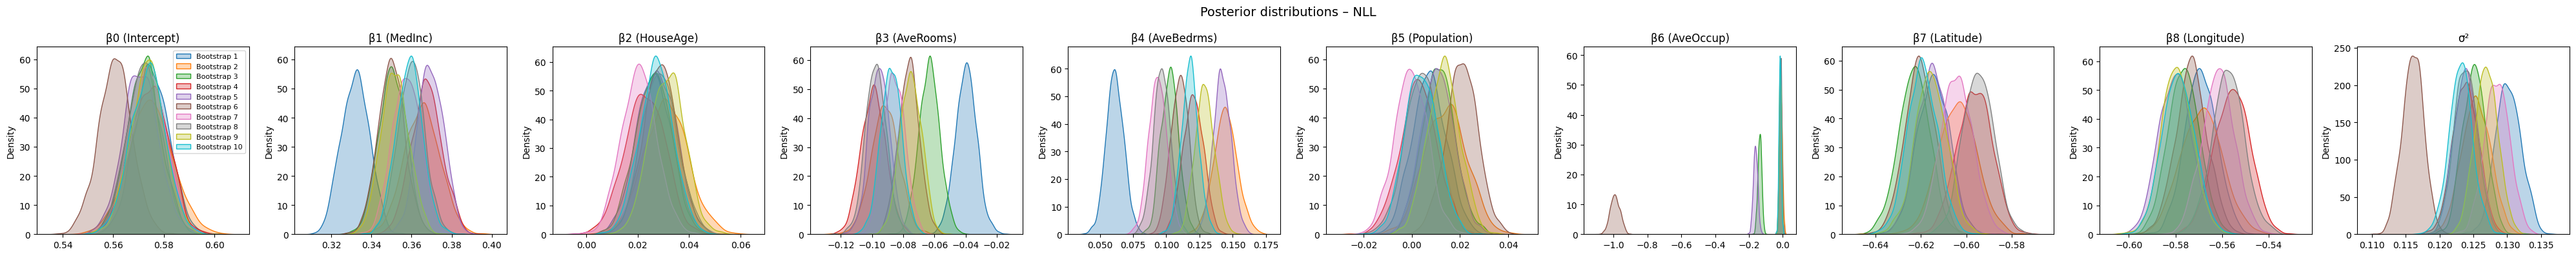

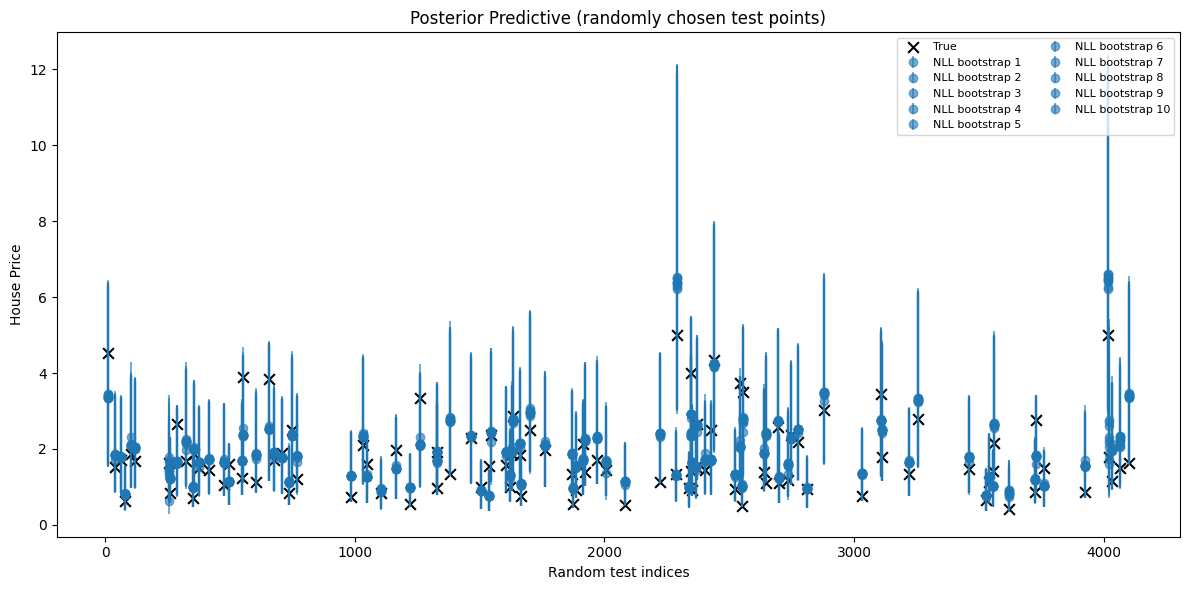


Predicted means for chosen points:
 Index    True Method  Bootstrap  Pred mean  Pred 2.5%  Pred 97.5%
    10 4.51800    NLL          1   3.339717   1.528227    6.359142
    10 4.51800    NLL          2   3.407218   1.578900    6.390336
    10 4.51800    NLL          3   3.384545   1.580528    6.349284
    10 4.51800    NLL          4   3.362836   1.574533    6.290504
    10 4.51800    NLL          5   3.436001   1.596560    6.440805
    10 4.51800    NLL          6   3.442449   1.643812    6.339818
    10 4.51800    NLL          7   3.350333   1.536387    6.352668
    10 4.51800    NLL          8   3.346102   1.552124    6.258890
    10 4.51800    NLL          9   3.385835   1.562154    6.400186
    10 4.51800    NLL         10   3.371742   1.571194    6.283121
    37 1.53800    NLL          1   1.871396   0.874196    3.520039
    37 1.53800    NLL          2   1.829839   0.867261    3.400666
    37 1.53800    NLL          3   1.829687   0.862873    3.415939
    37 1.53800    NLL     

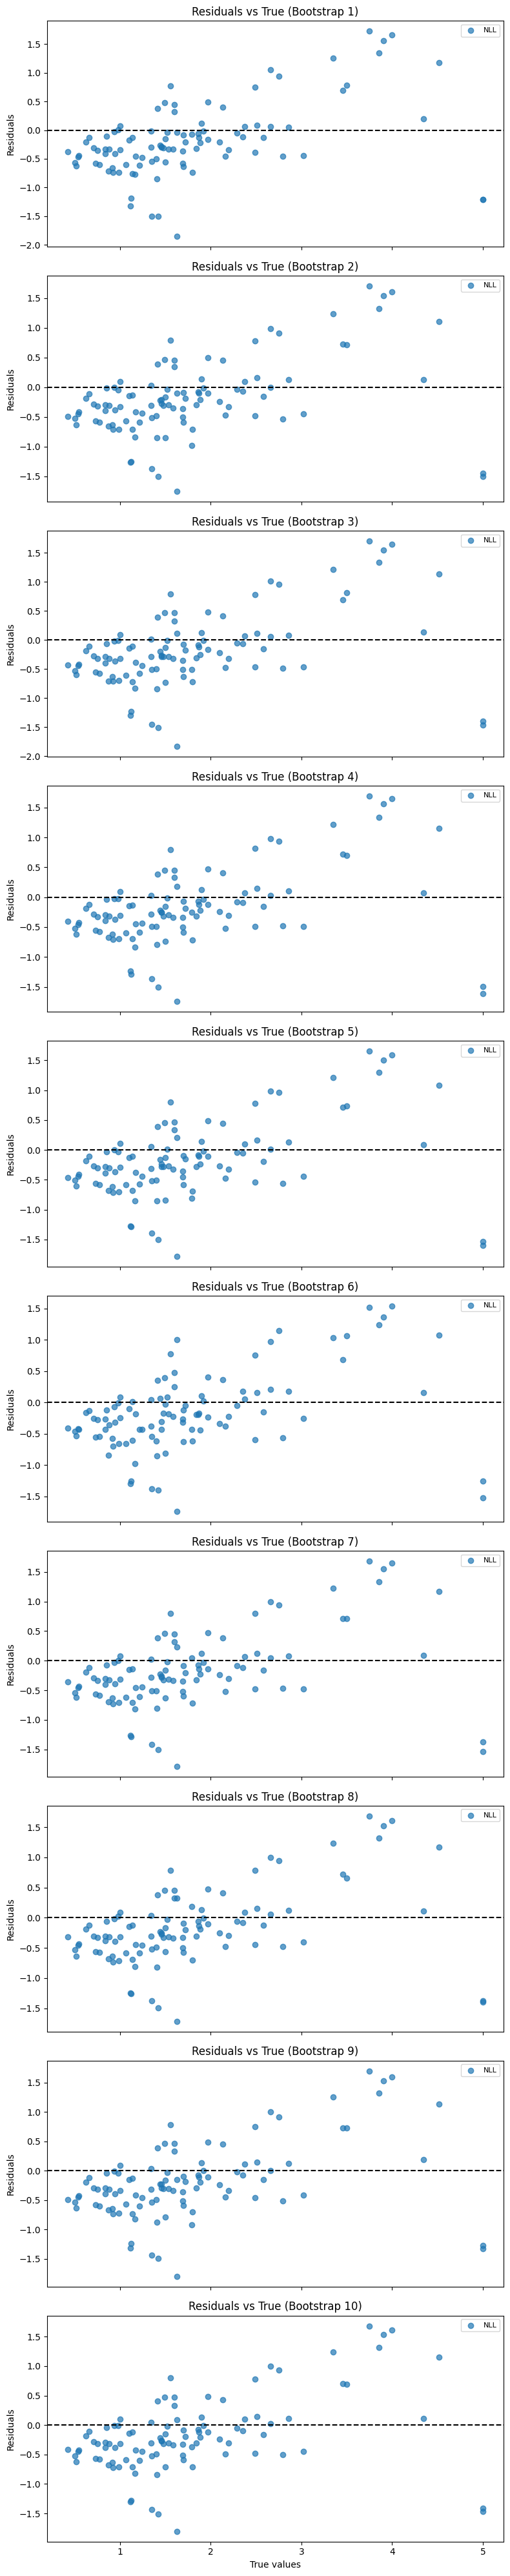


Training BETA on bootstrap 1...
Training complete: 1000 steps

Training BETA on bootstrap 2...
Training complete: 1000 steps

Training BETA on bootstrap 3...
Training complete: 1000 steps

Training BETA on bootstrap 4...
Training complete: 1000 steps

Training BETA on bootstrap 5...
Training complete: 1000 steps

Training BETA on bootstrap 6...
Training complete: 1000 steps

Training BETA on bootstrap 7...
Training complete: 1000 steps

Training BETA on bootstrap 8...
Training complete: 1000 steps

Training BETA on bootstrap 9...
Training complete: 1000 steps

Training BETA on bootstrap 10...
Training complete: 1000 steps


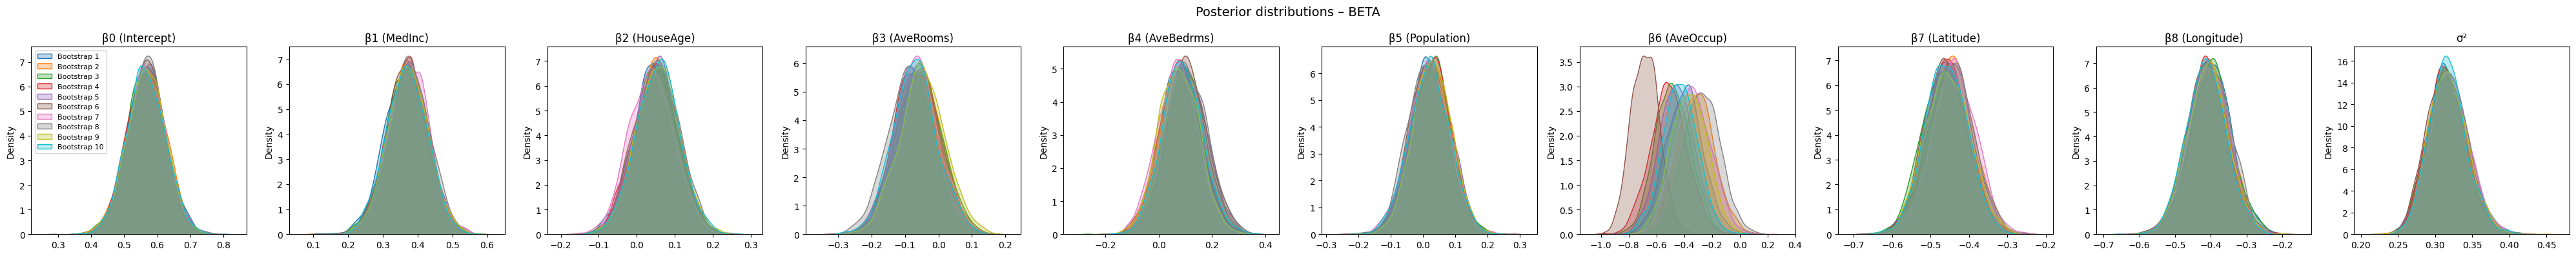

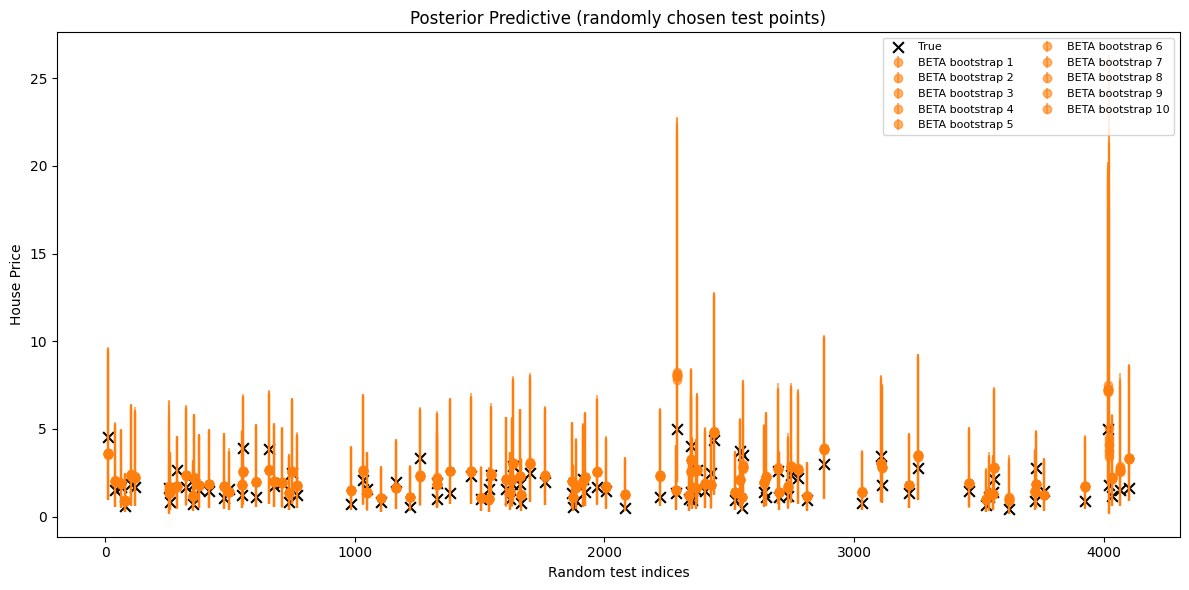


Predicted means for chosen points:
 Index    True Method  Bootstrap  Pred mean  Pred 2.5%  Pred 97.5%
    10 4.51800   BETA          1   3.529920   0.968624    9.304384
    10 4.51800   BETA          2   3.613338   0.984513    9.555972
    10 4.51800   BETA          3   3.549551   0.957823    9.199216
    10 4.51800   BETA          4   3.611329   0.977710    9.529783
    10 4.51800   BETA          5   3.620695   0.973374    9.530955
    10 4.51800   BETA          6   3.579792   0.960612    9.584434
    10 4.51800   BETA          7   3.653760   0.968476    9.601418
    10 4.51800   BETA          8   3.555368   0.948748    9.316813
    10 4.51800   BETA          9   3.634786   0.978306    9.674359
    10 4.51800   BETA         10   3.599162   0.965173    9.363754
    37 1.53800   BETA          1   2.047913   0.570264    5.276923
    37 1.53800   BETA          2   2.045168   0.577373    5.322031
    37 1.53800   BETA          3   2.030673   0.562807    5.167383
    37 1.53800   BETA     

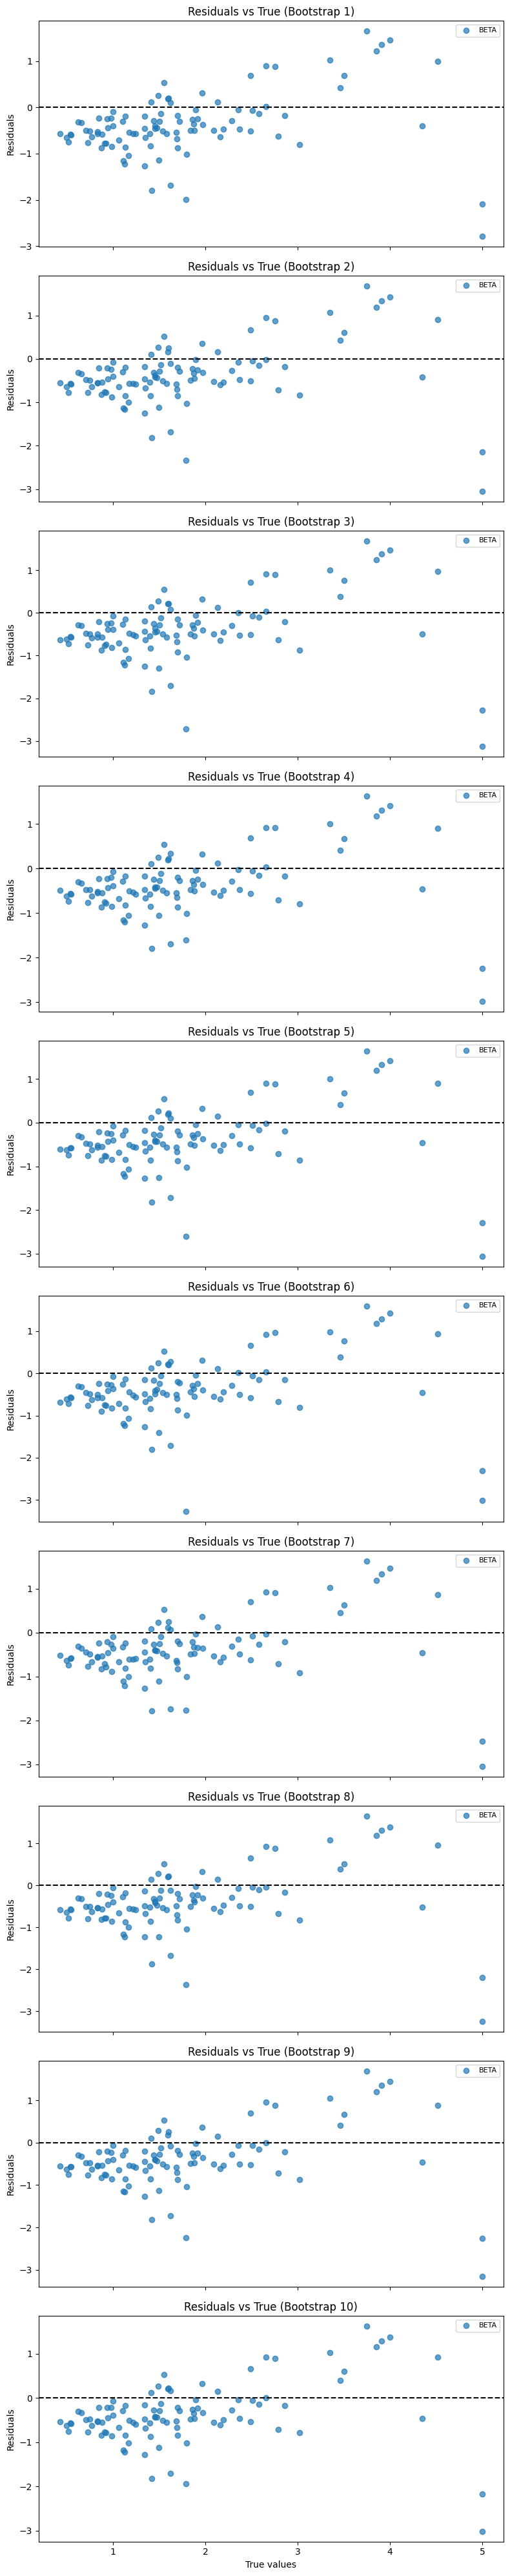


Training GAMMA on bootstrap 1...
Training complete: 1000 steps

Training GAMMA on bootstrap 2...
Training complete: 1000 steps

Training GAMMA on bootstrap 3...
Training complete: 1000 steps

Training GAMMA on bootstrap 4...
Training complete: 1000 steps

Training GAMMA on bootstrap 5...
Training complete: 1000 steps

Training GAMMA on bootstrap 6...
Training complete: 1000 steps

Training GAMMA on bootstrap 7...
Training complete: 1000 steps

Training GAMMA on bootstrap 8...
Training complete: 1000 steps

Training GAMMA on bootstrap 9...
Training complete: 1000 steps

Training GAMMA on bootstrap 10...
Training complete: 1000 steps


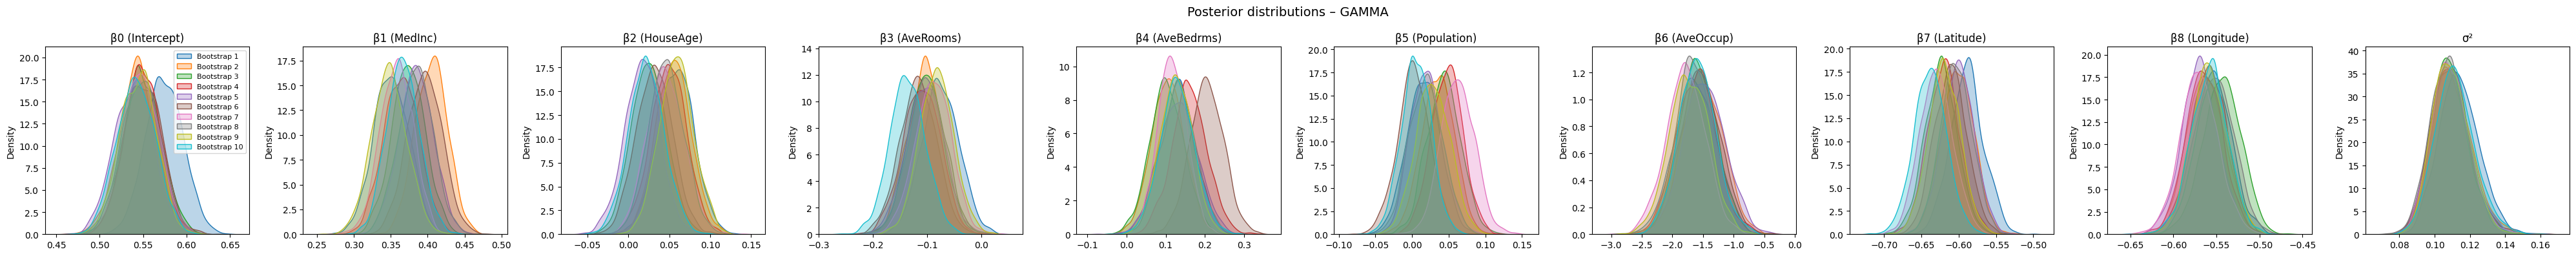

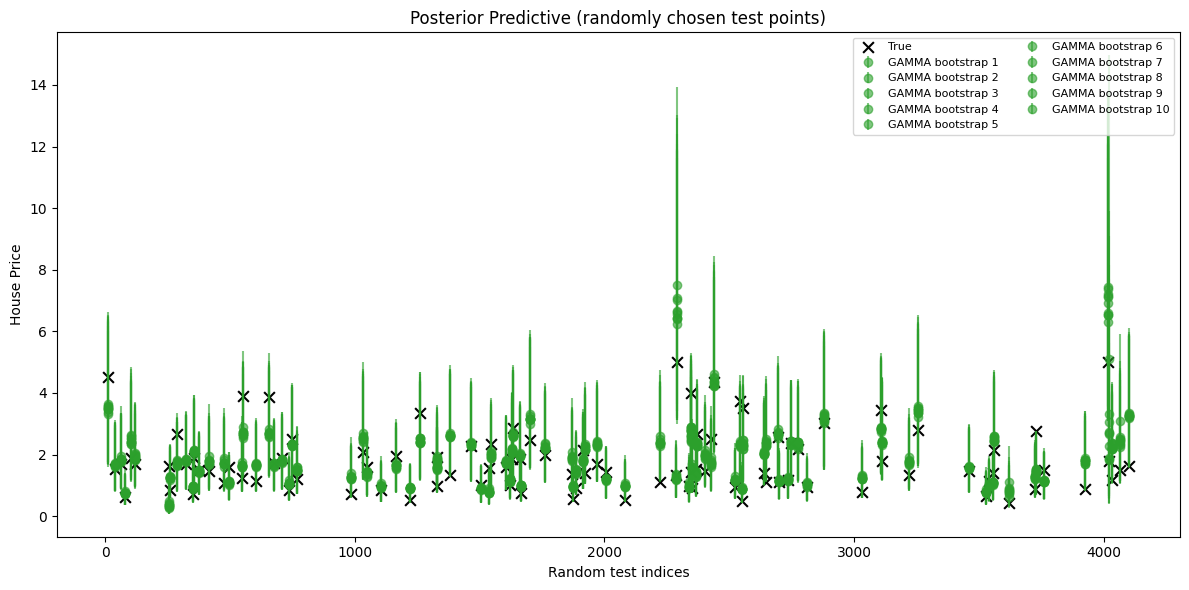


Predicted means for chosen points:
 Index    True Method  Bootstrap  Pred mean  Pred 2.5%  Pred 97.5%
    10 4.51800  GAMMA          1   3.544875   1.698657    6.535433
    10 4.51800  GAMMA          2   3.656239   1.770631    6.639921
    10 4.51800  GAMMA          3   3.479993   1.707805    6.309747
    10 4.51800  GAMMA          4   3.491916   1.691871    6.406800
    10 4.51800  GAMMA          5   3.577155   1.757129    6.460001
    10 4.51800  GAMMA          6   3.480121   1.706950    6.330289
    10 4.51800  GAMMA          7   3.569912   1.751987    6.497156
    10 4.51800  GAMMA          8   3.501779   1.718147    6.352715
    10 4.51800  GAMMA          9   3.380780   1.658395    6.162886
    10 4.51800  GAMMA         10   3.303269   1.589123    6.013302
    37 1.53800  GAMMA          1   1.720566   0.837990    3.120736
    37 1.53800  GAMMA          2   1.672735   0.823886    3.028041
    37 1.53800  GAMMA          3   1.664627   0.831191    2.967933
    37 1.53800  GAMMA     

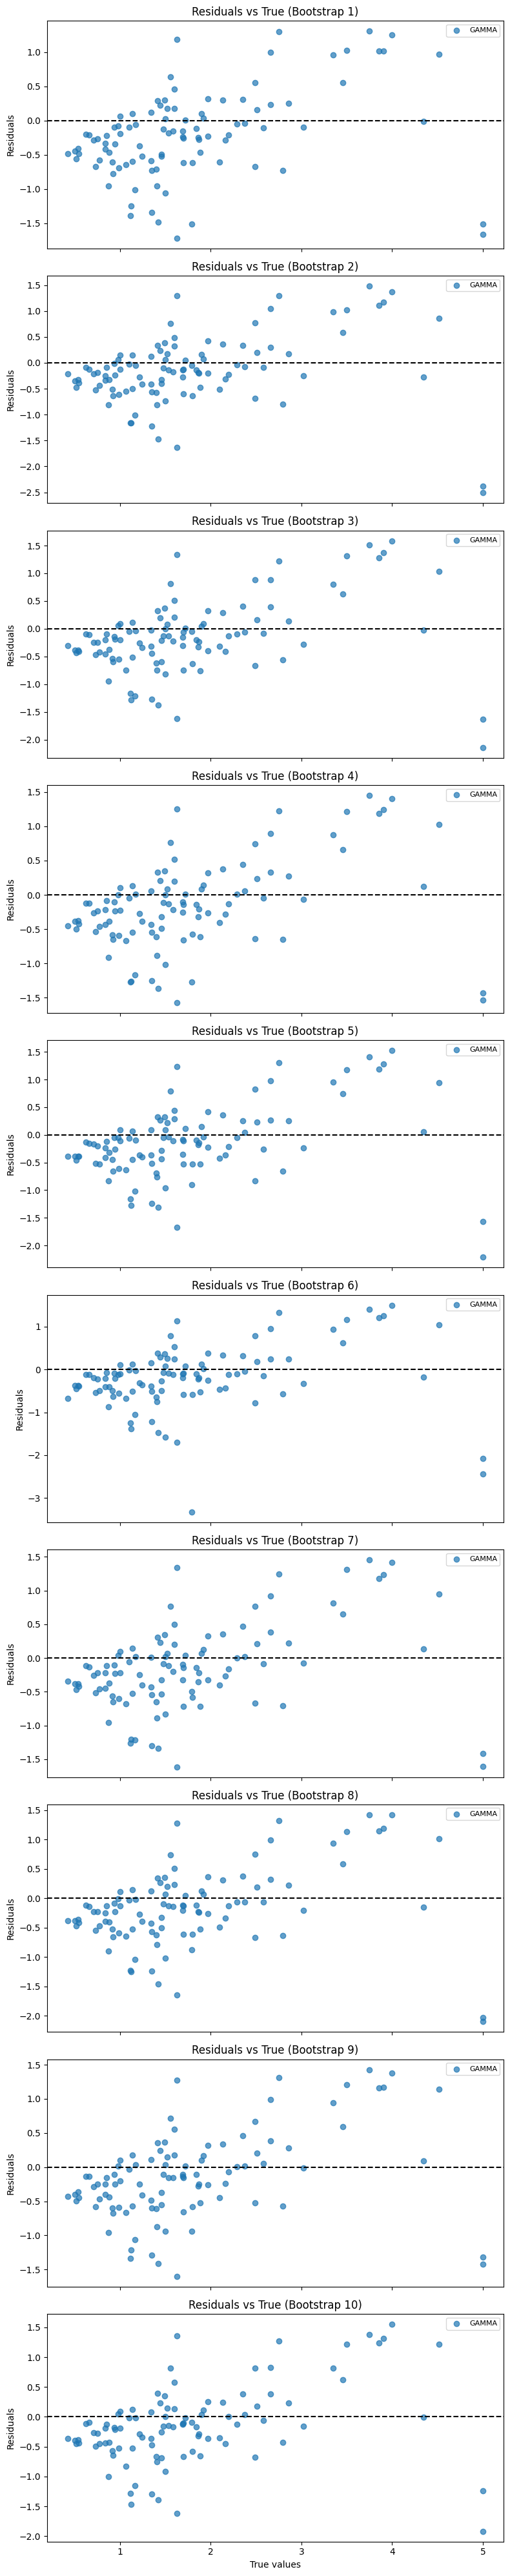

In [569]:
methods = [
    ("nll",   {"beta": None, "gamma": None}),
    ("beta",  {"beta": 1.1,  "gamma": None}),
    ("gamma", {"beta": None, "gamma": 0.1}),
    # ("pcuq",  {"beta": None, "gamma": None})#, 
    #("pvi-log", {}),
    #("pvi-crps", {})
]

feature_names = ["Intercept"] + california.feature_names
trained_results = {}  

for method, params in methods:
    q_list = []
    for j, (X_bs, y_bs) in enumerate(bootstraps, 1):
        print(f"\nTraining {method.upper()} on bootstrap {j}...")

        if method == "nll":
            qj = train_gvi_regression(
                X_bs, y_bs,
                loss_type="nll",
                steps=1000, lr=1e-2,
                prior_mean_beta=prior_mean_beta,
                prior_cov_beta=prior_cov_beta,
                prior_cov_inv=prior_cov_inv,
                logdet_prior_cov=logdet_prior_cov,
                alpha0=alpha0, beta0=beta0,
            )

        elif method == "beta":
            qj = train_gvi_regression(
                X_bs, y_bs,
                loss_type="beta",
                beta=params["beta"],
                steps=STEPS, lr=1e-3, batch_size=BATCH_SIZE, mc_samples=MC_SAMPLES,
                prior_mean_beta=prior_mean_beta,
                prior_cov_beta=prior_cov_beta,
                prior_cov_inv=prior_cov_inv,
                logdet_prior_cov=logdet_prior_cov,
                alpha0=alpha0, beta0=beta0,
            )

        elif method == "gamma":
            qj = train_gvi_regression(
                X_bs, y_bs,
                loss_type="gamma",
                gamma=params["gamma"],
                steps=STEPS, lr=1e-2, batch_size=BATCH_SIZE, mc_samples=MC_SAMPLES,
                prior_mean_beta=prior_mean_beta,
                prior_cov_beta=prior_cov_beta,
                prior_cov_inv=prior_cov_inv,
                logdet_prior_cov=logdet_prior_cov,
                alpha0=alpha0, beta0=beta0,
            )
        elif method == "pcuq":
            key = jrandom.PRNGKey(0)
            func_dict = build_func_dict(
                obs=jnp.array(y_bs),
                ts=jnp.array(X_bs),
                ls2=(sigma_mmd ** 2) / 2,   
                y0=0.0,       
                func=build_gaussian_lr,
                product=True,
            )

            n_features = X_bs.shape[1]
            n_particles = 10                
            reg_const = 1e-3
        
            from numpy.linalg import lstsq
            beta_ls = lstsq(X_bs, y_bs, rcond=None)[0]
            log_sigma_init = jnp.log(jnp.std(y_bs - X_bs @ beta_ls))
            bayes_init = jnp.concatenate([beta_ls, jnp.array([log_sigma_init])])
            
            params_init = jnp.stack([bayes_init] * n_particles, axis=0)
            rng, key = jrandom.split(key)
            params_init += 1e-6 *jrandom.normal(rng, params_init.shape)

            func = func_dict["bayes"]
            rng, key = jrandom.split(key)
            tr_bayes = mala(
                func=func,
                n_iters=5000,
                dt0=1e-5,
                params_init=params_init,
                reg_const = reg_const,
                key=rng,
                multi=True,
            )

  
            params_init2 = tr_bayes[-1]
            func = func_dict["mmd-bayes"]
            ys = build_gaussian_lr(0, jnp.array(X_bs), params_init)
            sigma = jnp.exp(params_init[-1])
            s2 = sigma**2
            kernel = lambda x, mu, s2: jnp.exp(jnp.sum(
                -0.5 * jnp.log(2*jnp.pi*s2) 
                - 0.5 * jnp.square(x-mu)/s2 
                + 0.5 * jnp.log(2*jnp.pi*(sigma_mmd ** 2) / 2)
            ))

            # k_val = kernel(y_bs[0:1], ys[0:1], s2 + (sigma_mmd ** 2) / 2)
            # print(f"Single kernel value: {k_val}")
            # print(f"Is it tiny? {k_val < 1e-10}")
            rng, key = jrandom.split(key)
            tr_crps = mala(
                func=func,
                n_iters=5000,
                dt0=1e-5,
                params_init=params_init2,
                reg_const=reg_const,
                key=rng,
                multi=True,
            )

            params_init3 = tr_crps[-1]
            func = func_dict["pcuq"]

            # # Check objective value and gradient at initialization
            # obj_val = func(params_init3)
            # grad_val = jax.grad(func)(params_init3)
            # initial_grad_norm = jnp.linalg.norm(jax.grad(func)(params_init3))

            # # Scale initial step size based on gradient
            # dt0_pcuq = 1e-6 * (1000 / initial_grad_norm) 
            # print(f"PCUQ init objective: {obj_val}")
            # print(f"PCUQ init gradient norm: {jnp.linalg.norm(grad_val)}")
            # print(f"PCUQ init gradient mean: {jnp.mean(jnp.abs(grad_val))}")
            # print(f"Sigma grads: {grad_val[:, -1]}")

            # # Compare to what you had before
            # obj_mmd = func_dict["mmd-bayes"](params_init3[0])  # Single particle
            # print(f"MMD objective at same point: {obj_mmd}")

            rng, key = jrandom.split(key)
            tr_pcuq = mala(
                func=func,
                n_iters=5000,
                dt0=1e-5,
                params_init=params_init3,
                reg_const=reg_const*0.1,
                key=rng,
                multi=False,      
            )
            trace_arr = np.array(tr_pcuq)         
            flat = trace_arr.reshape(-1, trace_arr.shape[-1])
            beta_samples   = flat[:, :-1]
            sigma2_samples = np.exp(2 * flat[:, -1])
            print("Posterior mean σ²:", sigma2_samples.mean())
            print("Posterior mean β (first 5):", beta_samples.mean(axis=0)[:5])
            qj = {
                "beta_samples": np.array(beta_samples),
                "sigma2_samples": np.array(sigma2_samples),
            }


        else:
            raise RuntimeError("Unknown method")

        q_list.append(qj)
    trained_results[method] = q_list
    plot_posteriors_all_betas({method: q_list}, num_samples=2000, feature_names=feature_names)
    plot_posterior_predictive_points(
        {method: q_list},
        X_test_np, y_test_np,        
        num_points=100, num_samples=10000,
        trained_on_log=True,
        centered=False,
        y_train_mean=y_train_mean,  
        seed=SEED
    )



In [570]:
def evaluate_metrics(q_list, X_test, y_test,
                     num_samples=1000, method_name="",
                     trained_on_log=True, centered=False, y_train_mean=0.0,
                     seed=123, max_samples=5000): 
    """
    Computes RMSE, NLPD, and CRPS on the RAW y scale when trained_on_log=True.
    
    Args:
        max_samples: Maximum number of samples to use (to prevent memory issues)
    """
    import numpy as np
    from scipy.stats import norm
    from scipy.special import logsumexp
    
    rng = np.random.default_rng(SEED)
    
    # --- CRPS (empirical) ---
    def crps_empirical(y, samples_row, max_pairs=2000):
        """Compute CRPS with subsampling if needed"""
        s = np.asarray(samples_row)
        n_samples = len(s)
        
        # Subsample if too many samples
        if n_samples > max_pairs:
            idx = rng.choice(n_samples, size=max_pairs, replace=False)
            s = s[idx]
        
        term1 = np.mean(np.abs(s - y))
        term2 = 0.5 * np.mean(np.abs(s[:, None] - s[None, :]))
        return term1 - term2
    
    results = []
    
    for b, q in enumerate(q_list, 1):
        try:
            # ---- Determine posterior type and extract samples ----
            
            # Type 1: Dictionary
            if isinstance(q, dict):
                if "beta_samples" in q and "sigma2_samples" in q:
                    beta_samples = np.asarray(q["beta_samples"])
                    sigma2_samples = np.asarray(q["sigma2_samples"])
                    is_empirical = True
                else:
                    raise ValueError("Dict must contain 'beta_samples' and 'sigma2_samples'")
            
            # Type 2: Tuple
            elif isinstance(q, tuple) and len(q) == 2:
                beta_samples = np.asarray(q[0])
                sigma2_samples = np.asarray(q[1])
                is_empirical = True
            
            # Type 3: JAX/NumPy array (trace from MALA)
            elif isinstance(q, (np.ndarray)):
                q_np = np.asarray(q)
                
                if q_np.ndim == 3:
                    # [n_iters, n_particles, n_params]
                    n_iters, n_particles, n_params = q_np.shape
                    print(f"   Trace shape: {q_np.shape} -> {n_iters * n_particles} samples")
                    
                    # Subsample if too many samples
                    total_samples = n_iters * n_particles
                    if total_samples > max_samples:
                        print(f"   Subsampling {total_samples} -> {max_samples} samples")
                        # Randomly select iterations
                        n_keep = max_samples // n_particles
                        iter_idx = rng.choice(n_iters, size=n_keep, replace=False)
                        q_np = q_np[iter_idx]
                        total_samples = n_keep * n_particles
                    
                    q_flat = q_np.reshape(-1, n_params)
                    beta_samples = q_flat[:, :-1]
                    log_sigma = q_flat[:, -1]
                    sigma2_samples = np.exp(2 * log_sigma)
                    
                elif q_np.ndim == 2:
                    n_iters, n_params = q_np.shape
                    print(f"   Trace shape: {q_np.shape}")
                    if n_iters > max_samples:
                        print(f"   Subsampling {n_iters} -> {max_samples} samples")
                        iter_idx = rng.choice(n_iters, size=max_samples, replace=False)
                        q_np = q_np[iter_idx]
                    
                    beta_samples = q_np[:, :-1]
                    log_sigma = q_np[:, -1]
                    sigma2_samples = np.exp(2 * log_sigma)
                else:
                    raise ValueError(f"Unexpected array shape: {q_np.shape}")
                
                is_empirical = True
            elif isinstance(q, list):
                q_array = np.array(q)
                return evaluate_metrics(
                    [q_array] if b == 1 else q_list,
                    X_test, y_test, num_samples, method_name,
                    trained_on_log, centered, y_train_mean, SEED, max_samples
                )
            elif hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
                beta_samples = q.sample_beta(num_samples).detach().cpu().numpy()
                sigma2_samples = q.sample_sigma2(num_samples).detach().cpu().numpy()
                is_empirical = False
            
            else:
                raise TypeError(f"Unsupported posterior type: {type(q)}")
            beta_samples = np.asarray(beta_samples, dtype=np.float32)
            sigma2_samples = np.asarray(sigma2_samples, dtype=np.float32)
            
            if beta_samples.ndim == 1:
                beta_samples = beta_samples.reshape(1, -1)
            if sigma2_samples.ndim == 0:
                sigma2_samples = sigma2_samples.reshape(1)
            elif sigma2_samples.ndim == 2:
                sigma2_samples = sigma2_samples.flatten()
    
            S = beta_samples.shape[0]
            if S > max_samples:
                print(f"   Final subsampling: {S} -> {max_samples}")
                idx = rng.choice(S, size=max_samples, replace=False)
                beta_samples = beta_samples[idx]
                sigma2_samples = sigma2_samples[idx]
                S = max_samples
            
            if sigma2_samples.shape[0] != S:
                if sigma2_samples.shape[0] == 1:
                    sigma2_samples = np.repeat(sigma2_samples, S)
                else:
                    raise ValueError(f"Sample mismatch: beta={S}, sigma2={sigma2_samples.shape[0]}")
            
            X_test_np = np.asarray(X_test, dtype=np.float32)
            y_true_in = np.asarray(y_test).reshape(-1)
            n = X_test_np.shape[0]
            
            print(f"   Computing predictions with {S} samples...")
    
            means = X_test_np @ beta_samples.T 
            sigma_s = np.sqrt(np.clip(sigma2_samples, 1e-12, None)).reshape(1, -1)

            if trained_on_log:
                mu_log = means + (y_train_mean if centered else 0.0)
                y_true_raw = np.exp(y_true_in + (y_train_mean if centered else 0.0))
            else:
                mu_log = means
                y_true_raw = y_true_in
            print("="*50)
            print(f"[DEBUG] Method={method_name} Bootstrap={b}")
            print("sigma2 mean:", float(np.mean(sigma2_samples)))
            print("sigma2 max :", float(np.max(sigma2_samples)))
            print("sigma2 99% :", float(np.percentile(sigma2_samples, 99)))

            print("mu_log mean:", float(np.mean(mu_log)))
            print("mu_log std :", float(np.std(mu_log)))
            print("mu_log min :", float(np.min(mu_log)))
            print("mu_log max :", float(np.max(mu_log)))
            print("="*50)
            eps = rng.normal(0.0, 1.0, size=(n, S))
            if trained_on_log:
                pred_samples = np.exp(mu_log + eps * sigma_s)
            else:
                pred_samples = mu_log + eps * sigma_s
        
            y_pred_mean = pred_samples.mean(axis=1)
            rmse = float(np.sqrt(np.mean((y_true_raw - y_pred_mean) ** 2)))

            print(f"   Computing NLPD...")
            logps = []
            for i in range(n):
                if trained_on_log:
                    logy = np.log(np.maximum(y_true_raw[i], 1e-12))
                    comp = (
                        norm.logpdf(logy, loc=mu_log[i], scale=sigma_s.flatten())
                        - np.log(np.maximum(y_true_raw[i], 1e-12))
                    )
                else:
                    comp = norm.logpdf(y_true_raw[i], loc=mu_log[i], scale=sigma_s.flatten())
                logps.append(logsumexp(comp) - np.log(S))
            nlpd = -float(np.mean(logps))
            
            # CRPS
            print(f"   Computing CRPS...")
            crps_vals = []
            for i in range(n):
                crps_i = crps_empirical(y_true_raw[i], pred_samples[i])
                crps_vals.append(crps_i)
            crps = float(np.mean(crps_vals))
            
            results.append({
                "Method": method_name,
                "Bootstrap": b,
                "RMSE": rmse,
                "NLPD": nlpd,
                "CRPS": crps,
            })
            
            print(f"[{method_name} bootstrap {b}] RMSE={rmse:.4f}, NLPD={nlpd:.4f}, CRPS={crps:.4f}")
        
        except Exception as e:
            print(f"[ERROR in {method_name} bootstrap {b}]: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return results



In [ ]:
import pandas as pd
import torch
import numpy as np

all_eval_results = []
all_methods_to_eval = {}

for method in trained_results.keys():
    # collect individual bootstraps
    bootstraps = trained_results.get(method, [])
    
    
    # Store both variants under consistent names
    all_methods_to_eval[method] = bootstraps
    
    # add "_bagged" version only if it exists

for method, q_list in all_methods_to_eval.items():
    print(f"\n=== Evaluating {method.upper()} ===")
    
    fixed_q_list = []
    for q in q_list:
        # ---- Handle different posterior types ----
        
        # Type 1: Tuple (beta_samples, sigma2_samples)
        if isinstance(q, tuple):
            q_fixed = {
                "beta_samples": np.asarray(q[0]),
                "sigma2_samples": np.asarray(q[1]),
            }
        
        # Type 2: Dictionary
        elif isinstance(q, dict):
            # Already in correct format, just ensure numpy
            q_fixed = {
                "beta_samples": np.asarray(q["beta_samples"]),
                "sigma2_samples": np.asarray(q["sigma2_samples"]),
            }
        
        # Type 3: JAX/NumPy array (trace from MALA)
        elif isinstance(q, (np.ndarray, type(None))):
            try:
                import jax.numpy as jnp
                if isinstance(q, jnp.ndarray):
                    q = np.asarray(q)
            except:
                pass
            
            if q is None:
                print(f"[Warning] None value in {method}, skipping.")
                continue
            
            # Let evaluate_metrics handle the array directly
            # It will extract beta and sigma2 automatically
            fixed_q_list.append(q)
            continue
        
        # Type 4: List (trace from MALA as list)
        elif isinstance(q, list):
            # Convert to array and let evaluate_metrics handle it
            q_array = np.array(q)
            fixed_q_list.append(q_array)
            continue
        
        # Type 5: Variational posterior object with sample methods
        elif hasattr(q, "sample_beta") and hasattr(q, "sample_sigma2"):
            try:
                betas = q.sample_beta(2000).detach().cpu().numpy()
                sig2s = q.sample_sigma2(2000).detach().cpu().numpy()
                q_fixed = {"beta_samples": betas, "sigma2_samples": sig2s}
            except Exception as e:
                print(f"[Warning] Could not sample from {type(q)}: {e}")
                continue
        
        # Type 6: Object with beta_samples and sigma2_samples attributes
        elif hasattr(q, "beta_samples") and hasattr(q, "sigma2_samples"):
            try:
                beta_attr = q.beta_samples
                sigma2_attr = q.sigma2_samples
                
                # Handle torch tensors
                if torch.is_tensor(beta_attr):
                    beta_attr = beta_attr.detach().cpu().numpy()
                if torch.is_tensor(sigma2_attr):
                    sigma2_attr = sigma2_attr.detach().cpu().numpy()
                
                q_fixed = {
                    "beta_samples": np.asarray(beta_attr),
                    "sigma2_samples": np.asarray(sigma2_attr),
                }
            except Exception as e:
                print(f"[Warning] Could not extract attributes from {type(q)}: {e}")
                continue
        
        else:
            print(f"[Warning] Unsupported posterior type {type(q)} — skipping.")
            continue
        
        fixed_q_list.append(q_fixed)
    
    if not fixed_q_list:
        print(f"[Warning] No valid posteriors for method {method}, skipping.")
        continue
    
    # ---- Evaluate metrics ----
    try:
        evals = evaluate_metrics(
            fixed_q_list,
            X_test_np,
            y_test_np,
            num_samples=3000,
            method_name=method,
            trained_on_log=True,
            centered=False,
            y_train_mean=y_train_mean,
            seed = SEED
        )
        
        if isinstance(evals, list):
            all_eval_results.extend(evals)
        else:
            all_eval_results.append(evals)
    
    except Exception as e:
        print(f"[Error] Failed to evaluate {method}: {e}")
        import traceback
        traceback.print_exc()
        continue

# ---- Display results ----
df_results = pd.DataFrame(all_eval_results)

print("\n" + "="*80)
print("PER-BOOTSTRAP (AND BAGGED) EVALUATION:")
print("="*80)

if not df_results.empty:
    # Sort by method name for cleaner display
    df_results_sorted = df_results.sort_values(['Method', 'Bootstrap'])
    print(df_results_sorted.to_string(index=False))
else:
    print("⚠️ No evaluation results found.")

# ---- Summary statistics ----
if not df_results.empty and all(c in df_results.columns for c in ["RMSE", "NLPD", "CRPS"]):
    print("\n" + "="*80)
    print("SUMMARY ACROSS BOOTSTRAPS AND BAGGED POSTERIORS:")
    print("="*80)
    
    summary = (
        df_results.groupby("Method")[["RMSE", "NLPD", "CRPS"]]
        .agg(["mean", "std"])
        .round(4)
    )
    print(summary)
    
    # ---- Additional: Best method by metric ----
    print("\n" + "="*80)
    print("BEST METHOD BY METRIC (lower is better):")
    print("="*80)
    
    method_means = df_results.groupby("Method")[["RMSE", "NLPD", "CRPS"]].mean()
    
    for metric in ["RMSE", "NLPD", "CRPS"]:
        best_method = method_means[metric].idxmin()
        best_value = method_means[metric].min()
        print(f"{metric:8s}: {best_method:30s} = {best_value:.4f}")
    
else:
    print("\n⚠️ No valid evaluation results to summarize.")

# ---- Optional: Save to CSV ----
if not df_results.empty:
    output_file = "evaluation_results.csv"
    df_results.to_csv(output_file, index=False)